In [1]:
from MieSppForce import  green_func, frenel, dipoles, force
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad

In [2]:
c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7

def get_directivity(wl, P,M, eps_Au):
    px,py,pz = P
    mx, my,mz = M
    ka = -1j*np.sqrt(1/(eps_Au(wl)+1))
    kspp = np.sqrt(eps_Au(wl)/(eps_Au(wl)+1))
    I = lambda phi:  np.abs((mx/c_const+1j*ka*py)*np.sin(phi) + (my/c_const - 1j*ka*px)*np.cos(phi) - kspp*pz)**2
    Imax = quad(I, 0, 2 * np.pi)[0]
    return  lambda phi: 2 * np.pi * I(phi) / Imax
    


In [3]:
eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')

R = 110
#148
dist = 2
#d=60
a_angle = np.pi/4
angle = 35*np.pi/180
point = [0,0,dist+R]
z0 = point[2]
wls=np.linspace(500,900,100)
phase = 0

k0 = lambda wl: 2*np.pi/wl/1e-9
omega = lambda wl: 2*np.pi*c_const/wl/1e-9

In [87]:

STOP=45

F_x = np.empty((len(wls), 8))
F_y = np.empty_like(F_x)
F_z = np.empty_like(F_x)

Fy_pxmz = np.empty(len(wls))
Fy_pzmx = np.empty(len(wls))
Fx_pymz = np.empty(len(wls))
Fx_pzmy = np.empty(len(wls))

F_x_pm_mp_1  = np.empty(len(wls))
F_x_pm_mp_2 = np.empty(len(wls))
F_y_pm_mp_1 = np.empty(len(wls))
F_y_pm_mp_2 = np.empty(len(wls))

P,M = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)

def AlphaE(R, eps_Si):
    return lambda wl: dipoles.alpha_v2(wl, R, eps_Si)[0]
def AlphaH(R, eps_Si):
    return lambda wl: dipoles.alpha_v2(wl, R, eps_Si)[1]

AlphaEE = AlphaE(R, eps_Si)
AlphaHH = AlphaH(R, eps_Si)

dxGExz = np.empty(len(wls), dtype=complex)
dxGHxz = np.empty_like(dxGExz)
dyGEyz = np.empty_like(dxGExz)
dyGHyz = np.empty_like(dxGExz) 


dxrotGHyz= np.empty(len(wls), dtype=complex)
dxrotGHzy= np.empty(len(wls), dtype=complex)
dyrotGHxz= np.empty(len(wls), dtype=complex)
dyrotGHzx= np.empty(len(wls), dtype=complex)

for i in tqdm(range(len(wls))):
    f =  force.F(wls[i], eps_Au, point, R, eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x[i,:] = f[0]
    F_y[i,:] = f[1]
    F_z[i,:] = f[2]
    p,m = dipoles.calc_dipoles_v2(wls[i], eps_Au, point, R, eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    dyrotGE, dyrotGH = green_func.dy_rot_green_E_H(wls[i], point[2], eps_Au, STOP)
    dxrotGE, dxrotGH = green_func.dx_rot_green_E_H(wls[i], point[2], eps_Au, STOP)
    
    dxGE,dxGH = green_func.dx_green_E_H(wls[i], point[2], eps_Au, STOP)
    dyGE,dyGH = green_func.dy_green_E_H(wls[i], point[2], eps_Au, STOP)
    
    dxGExz[i] = dxGE[0,2]
    dxGHxz[i] = dxGH[0,2]
    dyGEyz[i] = dyGE[1,2]
    dyGHyz[i] = dyGH[1,2]
    
    p,m = p[:,0],m[:,0]
    P[i,:],M[i,:]=p,m
    
    dxrotGHyz[i], dxrotGHzy[i] = dxrotGH[1,2], dxrotGH[2,1]
    dyrotGHxz[i], dyrotGHzx[i] = dyrotGH[0,2], dyrotGH[2,0]
    
   
    Fx_pymz_exact = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[1,2])  + k0(wls[i])**3/(12 * np.pi )) * np.real(p[1].conj()*m[2])

    Fx_pzmy_exact = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[2,1]) - k0(wls[i])**3/(12 * np.pi)) * np.real(p[2].conj() * m[1])
    
    F_x_pm_mp_1_i = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[1,2]) ) * np.real(p[1].conj()*m[2])
    
    F_x_pm_mp_2_i =  - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[2,1])) * np.real(p[2].conj() * m[1])
        
    Fy_pxmz_exact = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[0,2])  - k0(wls[i])**3/(12 * np.pi )) * np.real(p[0].conj()*m[2])

    Fy_pzmx_exact = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[2,0]) + k0(wls[i])**3/(12 * np.pi)) * np.real(p[2].conj() * m[0])
    
    F_y_pm_mp_1_i = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[0,2])) * np.real(p[0].conj()*m[2])
    
    F_y_pm_mp_2_i =  - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[2,0]) ) * np.real(p[2].conj() * m[0])

    Fy_pxmz[i] = Fy_pxmz_exact
    Fy_pzmx[i] = Fy_pzmx_exact
    Fx_pymz[i] = Fx_pymz_exact
    Fx_pzmy[i] = Fx_pzmy_exact
    
    F_x_pm_mp_1[i] = F_x_pm_mp_1_i
    F_x_pm_mp_2[i] = F_x_pm_mp_2_i
    F_y_pm_mp_1[i] = F_y_pm_mp_1_i
    F_y_pm_mp_2[i] = F_y_pm_mp_2_i
        

 12%|█▏        | 12/100 [00:24<03:06,  2.12s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
 42%|████▏     | 42/100 [01:35<02:23,  2.48s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:441: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
100%|██████████| 100/100 [04:06<00:00,  2.47s/it]


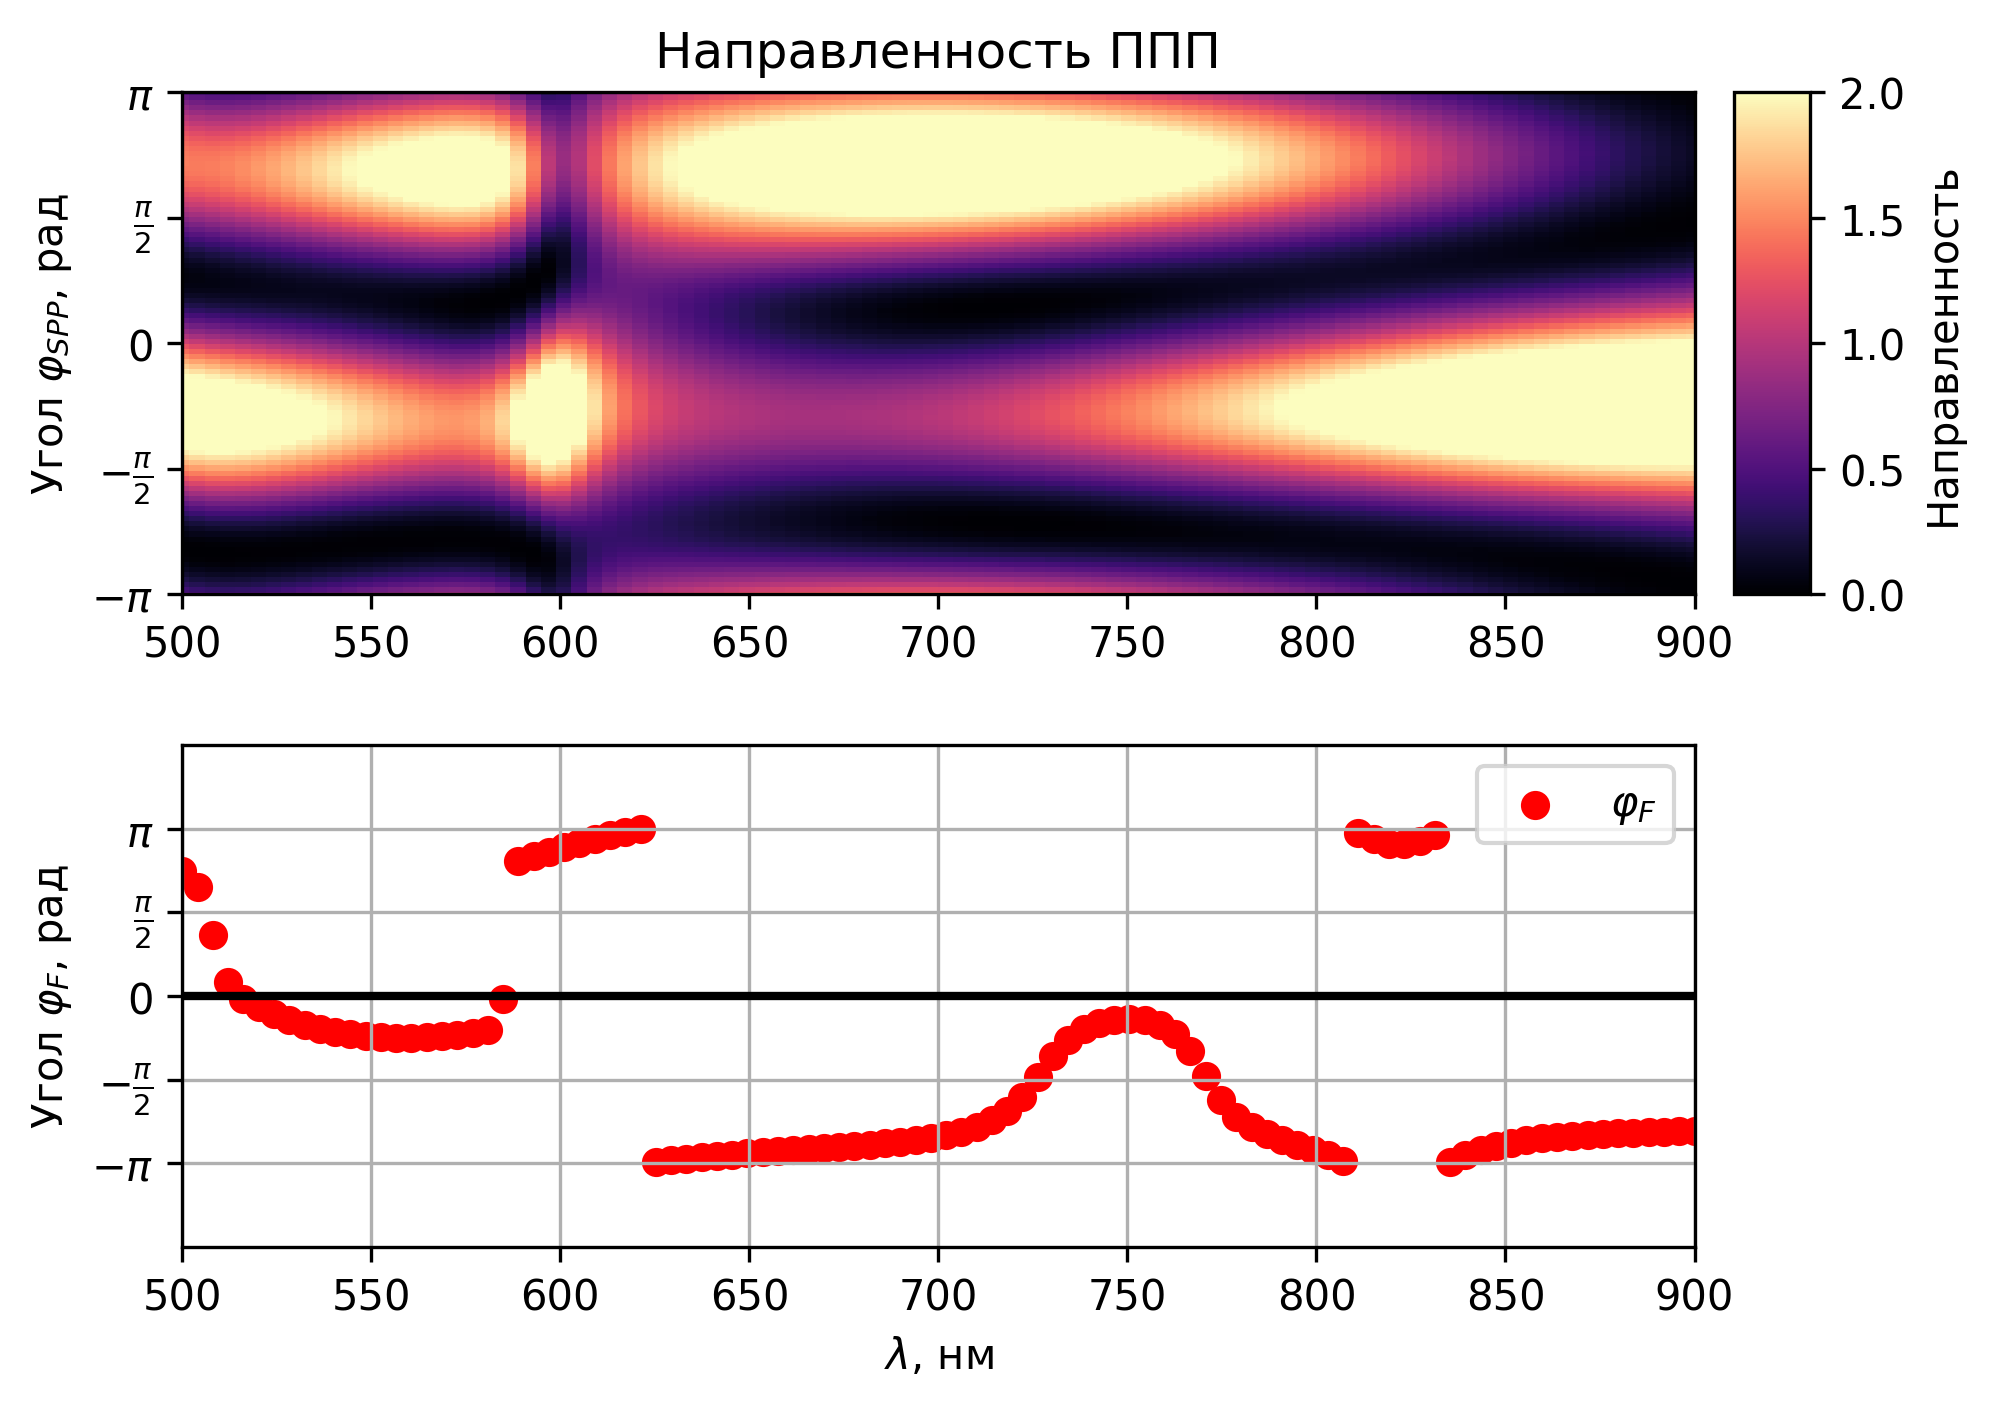

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

PHI = np.linspace(-np.pi, np.pi, 100)

directivity = np.empty((len(PHI), len(wls)))
for wl_idx, wl in enumerate(wls):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, P[wl_idx,:], M[wl_idx,:], eps_Au)
        directivity[angle_idx, wl_idx] = D(PHI[angle_idx])



# === Создание фигуры и макета ===
fig = plt.figure(figsize=(7, 5), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# === Верхний график (тепловая карта) ===
ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(wls, PHI, directivity, cmap='magma', vmax=2, vmin=0)

# Настройка оси Y: метки углов в виде кратных π
# y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
# y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_top.set_yticks(y_ticks)
ax_top.set_yticklabels(y_ticklabels)

ax_top.set_ylim(-np.pi, np.pi)
ax_top.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_top.set_title('Направленность ППП')

# === Colorbar ===
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Направленность')

# === Нижний график (углы силы) ===
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)

angles_no_sc= np.arctan2(F_y[:, 0], F_x[:, 0] - F_x[:, 1]-F_x[:,4])

angles_only_fpp = np.arctan2(F_y[:, 2], F_x[:, 2])
#angles_no_sc= np.unwrap(angles_no_sc)

# Отрисовка угла


# Границы и метки оси Y
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_bottom.set_yticks(y_ticks)
ax_bottom.set_yticklabels(y_ticklabels)
ax_bottom.axhline(0, color='black', linestyle='-', linewidth=2)
# closest_to_zero_idx = np.argmin(np.abs(angles_no_sc_from_R))
# approx_zero_crossing_x = Rs[closest_to_zero_idx]
# ax_bottom.axvline(approx_zero_crossing_x, color='black', linestyle='--', linewidth=2)
ax_bottom.scatter(wls, angles_no_sc, label=r'$\varphi_F$', color='r', linewidth=1)
ax_bottom.set_ylim(-9*np.pi/6, 9*np.pi/6)
ax_bottom.set_xlim(wls[0], wls[-1])
ax_bottom.set_xlabel('$\\lambda$, нм')
ax_bottom.set_ylabel(r'Угол $\varphi_F$, рад')
ax_bottom.grid(True)
ax_bottom.legend()
plt.savefig(f'spp_vs_f_nosc_from_wl_z0_{point[2]}_R_{R}_phase_{round(phase,2)}_beta_{round(a_angle,2)}.png', dpi=300)



In [ ]:
Rss = np.linspace(10, 150, 100)
wl=800

P_from_r,M_from_r = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)


for i in tqdm(range(len(Rss))):
    p,m = dipoles.calc_dipoles_v2(wl, eps_Au, point, Rss[i], eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    p,m = p[:,0],m[:,0]
    P_from_r[i,:],M_from_r[i,:]=p,m

100%|██████████| 100/100 [00:00<00:00, 3316.52it/s]


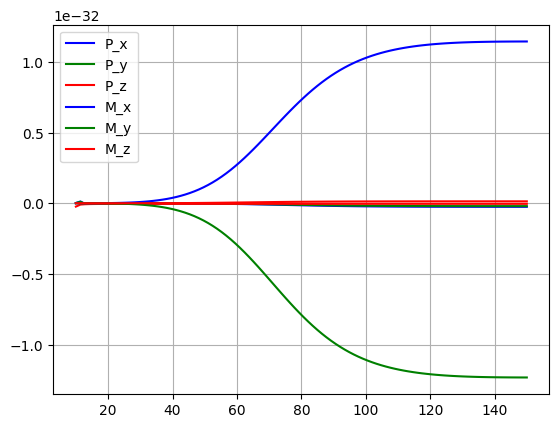

In [30]:
plt.plot(Rss, P_from_r[:,0].real, label='P_x', color='blue')
plt.plot(Rss, P_from_r[:,1].real, label='P_y', color='green')
plt.plot(Rss, P_from_r[:,2].real, label='P_z', color='red')

plt.plot(Rss, M_from_r[:,0].real/c_const, label='M_x', color='blue')
plt.plot(Rss, M_from_r[:,1].real/c_const, label='M_y', color='green')
plt.plot(Rss, M_from_r[:,2].real/c_const, label='M_z', color='red')

plt.legend()
plt.grid()

In [89]:
fmax_wls = 0
for i in range(len(wls)):
    f0 = force.F(wls[i], 1, [0,0,0], R, eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
    f0 = np.abs(f0)
    if f0 > fmax_wls:
        fmax_wls = f0

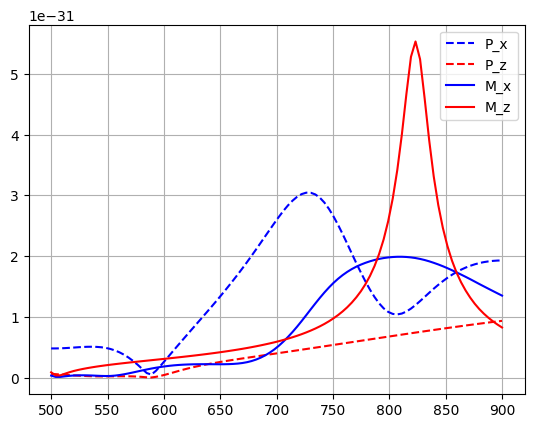

In [99]:
plt.plot(wls, np.abs(P[:,0]), label='P_x', color='blue', ls='--')
#plt.plot(wls, np.abs(P[:,1]), label='P_y', color='green', ls='--')   
plt.plot(wls, np.abs(P[:,2]), label='P_z', color='red', ls='--')

plt.plot(wls, np.abs(M[:,0])/c_const, label='M_x', color='blue')
#plt.plot(wls, np.abs(M[:,1])/c_const, label='M_y', color='green')   
plt.plot(wls, np.abs(M[:,2])/c_const, label='M_z', color='red')
plt.legend()
plt.grid()

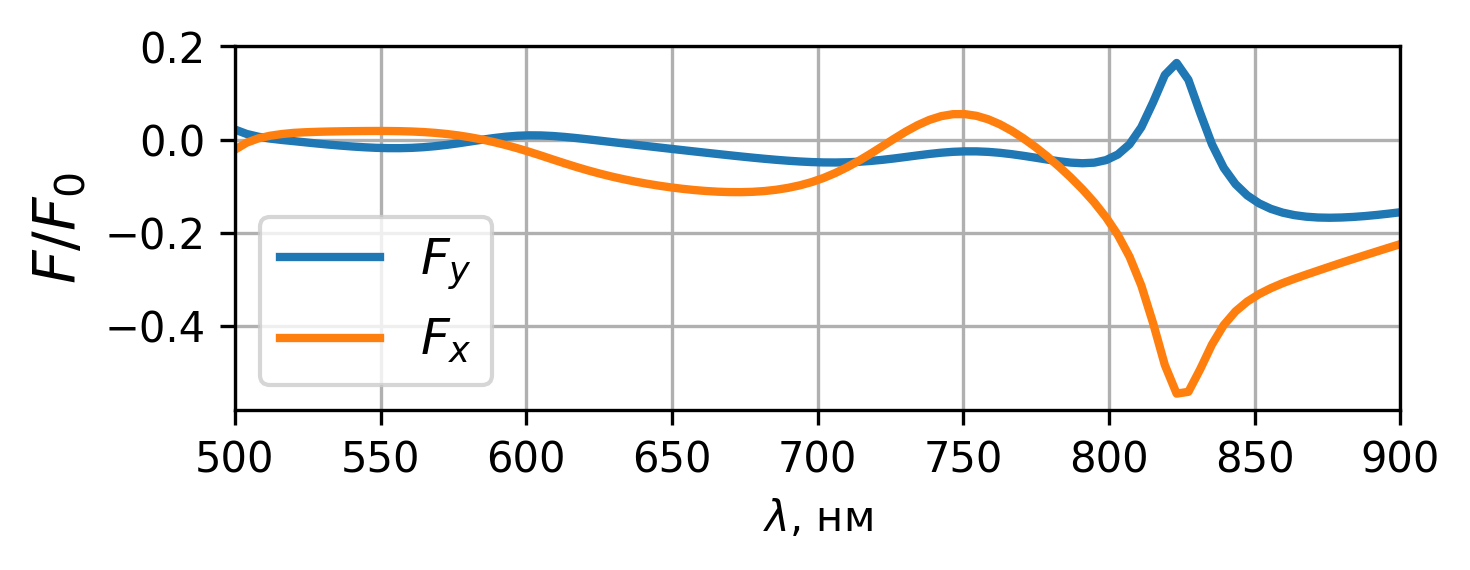

In [100]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2), sharex=True, dpi=300)


ax1.plot(wls, F_y[:,0]/fmax_wls, label='$F_y$', linewidth=2, color='#1f77b4')
ax1.plot(wls, (F_x[:,0]-F_x[:,1]-F_x[:,4])/fmax_wls, label='$F_x$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel('$F/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('$\\lambda$, нм')

plt.xlim(wls[0], wls[-1])

plt.tight_layout()
plt.savefig(f'f_no_sc_from_wl_z0_{point[2]}.pdf', dpi=300)
plt.show()




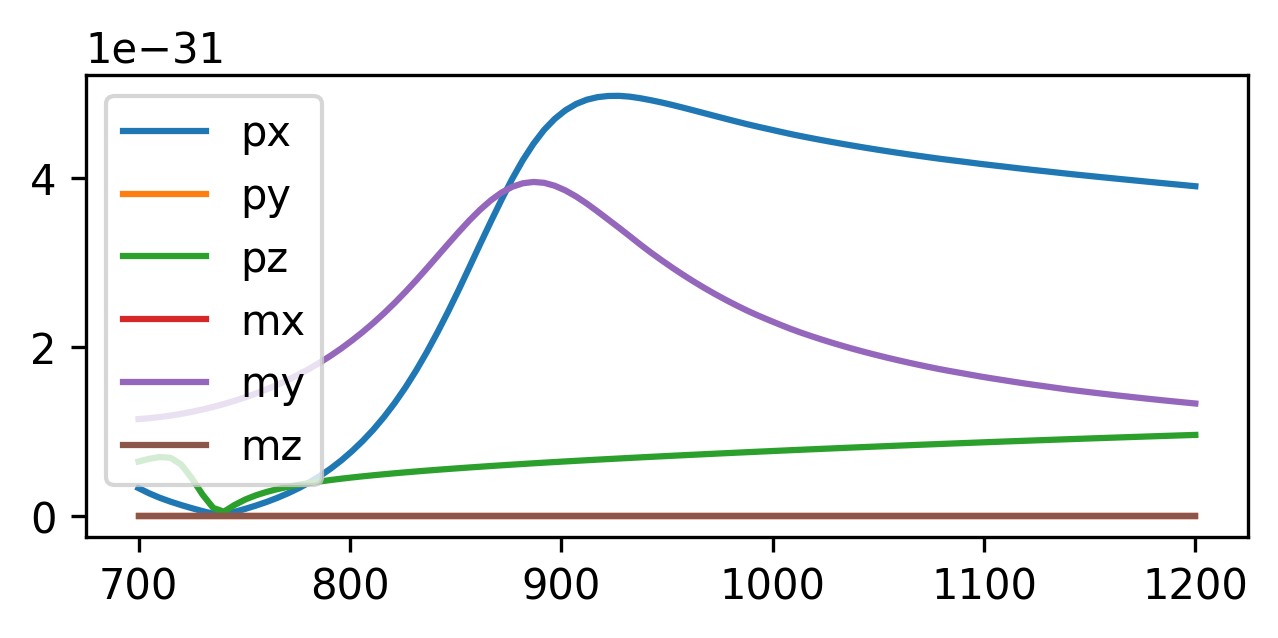

In [100]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, np.abs(P[:,0]), label='px')
plt.plot(wls, np.abs(P[:,1]), label='py')
plt.plot(wls, np.abs(P[:,2]), label='pz')
plt.plot(wls, np.abs(M[:,0])/c_const, label='mx')
plt.plot(wls, np.abs(M[:,1])/c_const, label='my')
plt.plot(wls, np.abs(M[:,2])/c_const, label='mz')
plt.legend()

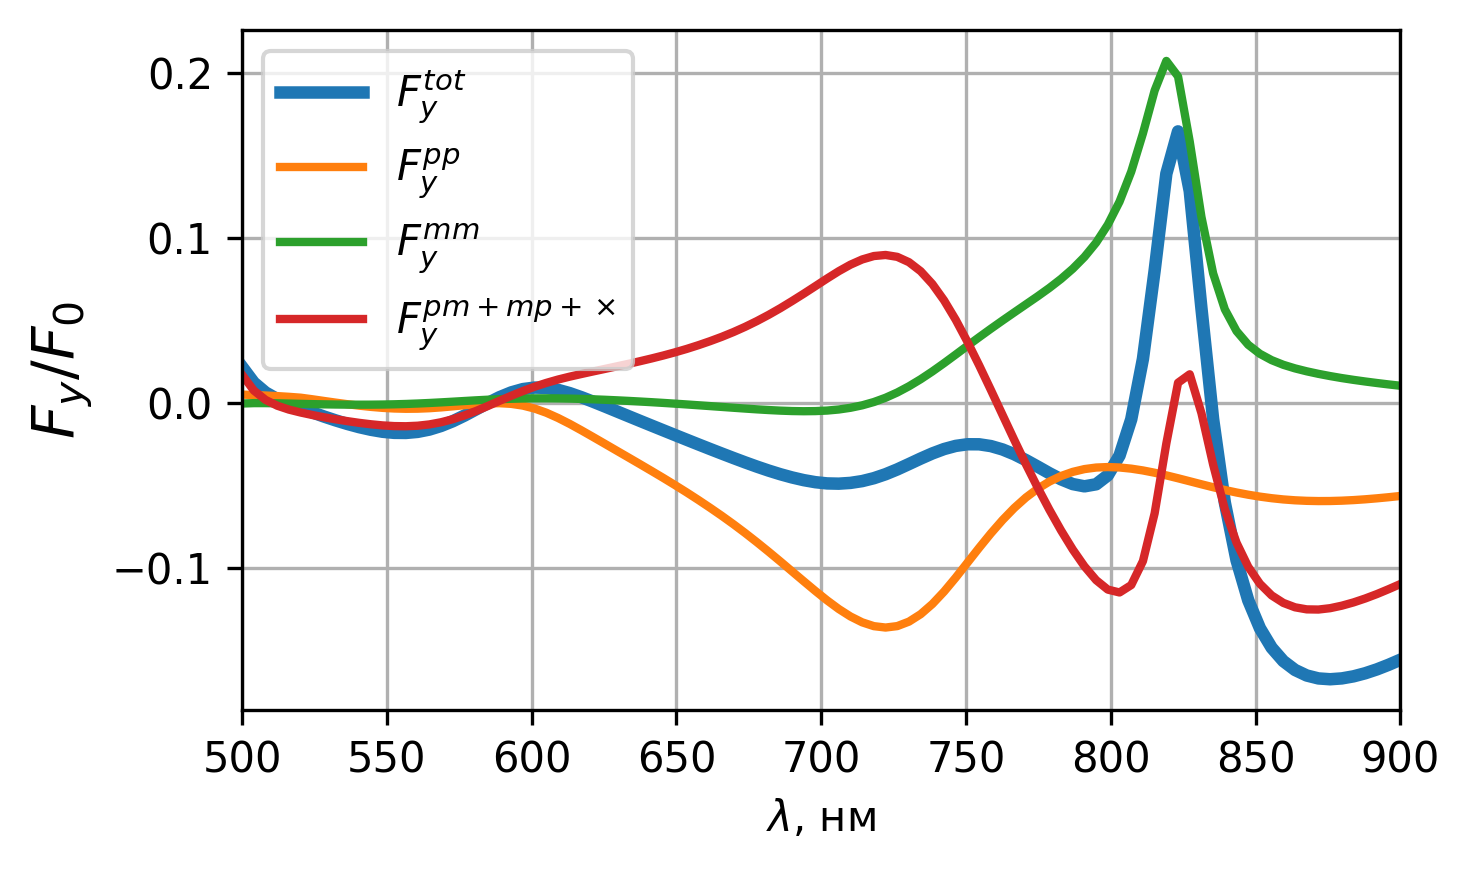

In [104]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(wls, F_y[:,0]/fmax_wls, label='$F_y^{tot}$', linewidth=3)
ax1.plot(wls, F_y[:,2]/fmax_wls, label='$F_y^{pp}$', linewidth=2)
ax1.plot(wls, F_y[:,5]/fmax_wls, label='$F_y^{mm}$', linewidth=2)
ax1.plot(wls, (F_y[:,6]+F_y[:,3]+F_y[:,7])/fmax_wls, label='$F_y^{pm+mp+\\times}$', linewidth=2)
#ax1.plot(wls, F_y[:,7]/fmax_wls, label='$F_y^{\\times}$', linewidth=2)

ax1.set_ylabel('$F_y/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_xlabel('$\\lambda$, нм')

plt.xlim(wls[0], wls[-1])

plt.tight_layout()
plt.savefig(f'f_y_no_sc_from_wl_z0_{point[2]}.png', dpi=300)
plt.show()




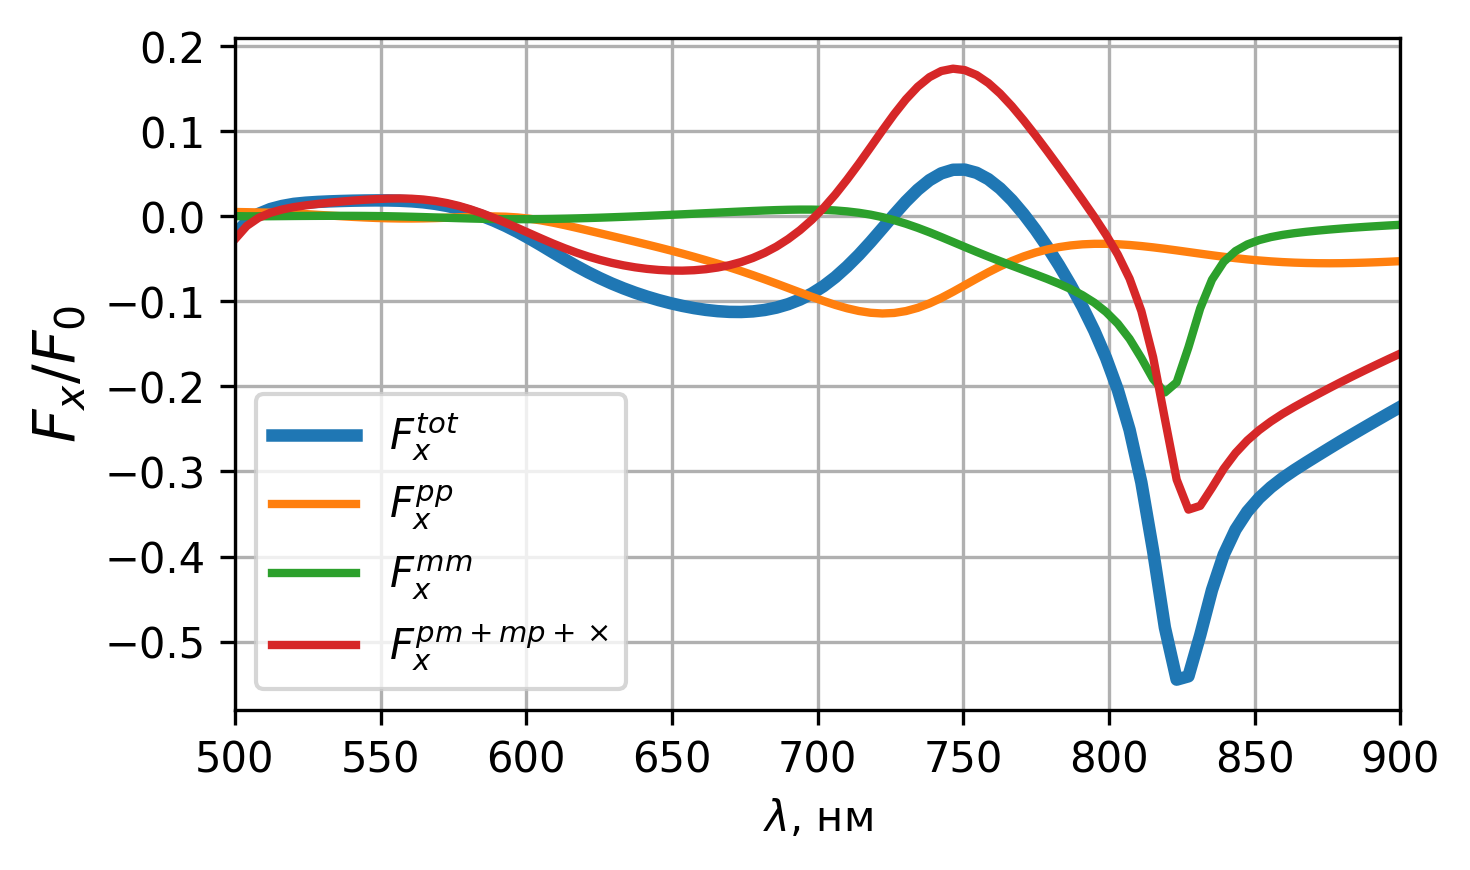

In [103]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(wls, (F_x[:,0]-F_x[:,1]-F_x[:,4])/fmax_wls, label='$F_x^{tot}$', linewidth=3)
ax1.plot(wls, F_x[:,2]/fmax_wls, label='$F_x^{pp}$', linewidth=2)
ax1.plot(wls, F_x[:,5]/fmax_wls, label='$F_x^{mm}$', linewidth=2)
ax1.plot(wls, (F_x[:,6]+F_x[:,3]+F_x[:,7])/fmax_wls, label='$F_x^{pm+mp+\\times}$', linewidth=2)
#ax1.plot(wls, F_y[:,7]/fmax_wls, label='$F_y^{\\times}$', linewidth=2)

ax1.set_ylabel('$F_x/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_xlabel('$\\lambda$, нм')

plt.xlim(wls[0], wls[-1])

plt.tight_layout()
plt.savefig(f'f_x_no_sc_from_wl_z0_{point[2]}.png', dpi=300)
plt.show()


In [230]:

STOP = 45
ANGLE = 35 * np.pi / 180
wl = 700

phase_values = np.linspace(-np.pi, np.pi, 50)
a_angle = np.linspace(0, np.pi/2, 50)
angles = np.linspace(0, 2 * np.pi, 100)

def compute_for_params(angle_index, pha, a_i):
    p, m = dipoles.calc_dipoles_v2(wl, eps_Au, point, R, eps_Si, ANGLE,
                                   amplitude=1, phase=pha, a_angle=a_i, stop=STOP)
    p, m = p[:, 0], m[:, 0]
    D = get_directivity(wl, p, m, eps_Au)
    D_angle = D(angles[angle_index])


    return angle_index, pha, a_i, D_angle, p, m


results = []


for angle_index in tqdm(range(len(angles))):
    for pha in phase_values:
        for a_i in a_angle:
            result = compute_for_params(angle_index, pha, a_i)
            results.append(result)

best_D = np.zeros(len(angles))
best_params = np.empty((len(angles), 2))
dipoles_p = np.empty((len(angles), 3), dtype=np.complex128)
dipoles_m = np.empty((len(angles), 3), dtype=np.complex128)

for i, pha, a_i, D, p, m in results:
    if D > best_D[i]:
        best_D[i] = D
        best_params[i] = (pha, a_i)
        dipoles_p[i] = p
        dipoles_m[i] = m



100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


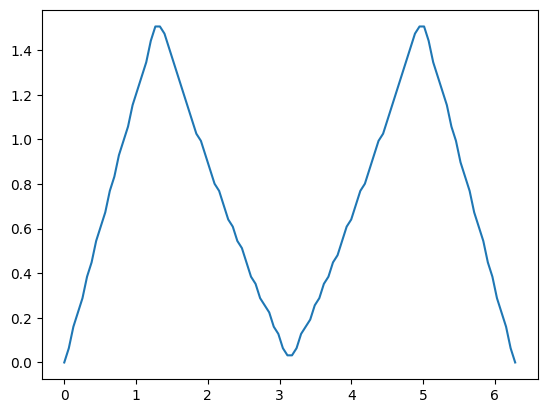

In [233]:
plt.plot(angles, np.unwrap(best_params[:,1]))

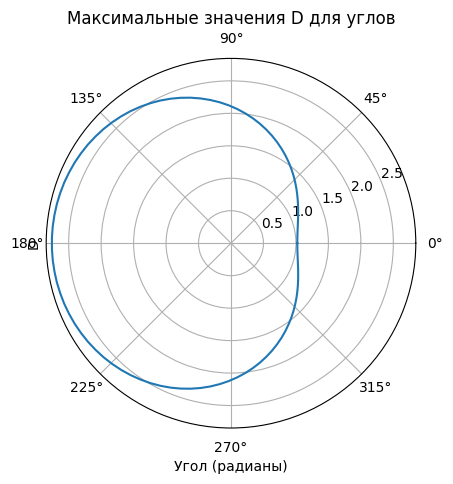

In [234]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, best_D)
ax.grid(True)
plt.xlabel("Угол (радианы)")
plt.ylabel("D")
ax.set_title("Максимальные значения D для углов")
plt.show()

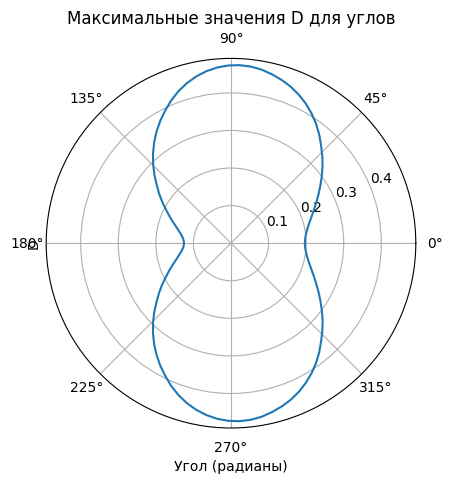

In [476]:
data = np.load("brute_spp_angle_optim.npz", allow_pickle=True)
best_D = data["best_D"]
best_params = data["best_params"]
angles = data["angles"]
best_dip_p = data["best_dip_p"]
best_dip_m = data["best_dip_m"]


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, best_D)
ax.grid(True)
plt.xlabel("Угол (радианы)")
plt.ylabel("D")
ax.set_title("Максимальные значения D для углов")
plt.show()

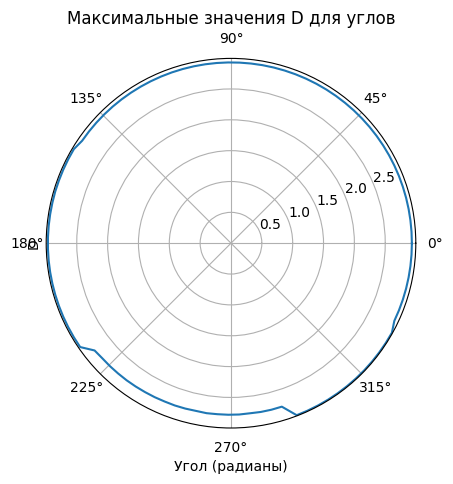

In [479]:
data = np.load("spp_angle_optim.npz", allow_pickle=True)
delta_D = data["delta_D"]
max_D = data["max_D"]
angles = data["angles"]
losses = data["losses"]
params = data["params"]



fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, max_D)
ax.grid(True)
plt.xlabel("Угол (радианы)")
plt.ylabel("D")
ax.set_title("Максимальные значения D для углов")
plt.show()

In [74]:
F_x_opt = np.empty((len(params), 8))
F_y_opt = np.empty((len(params), 8))
F_z_opt = np.empty((len(params), 8))
P_opt = np.empty((len(params), 3), dtype=complex)
M_opt = np.empty((len(params), 3), dtype=complex)
for i in tqdm(range(len(params))):
    p, m = dipoles.calc_dipoles_v2(params[i,0], eps_Au, point, R, eps_Si, ANGLE,amplitude=1, phase=params[0,1], a_angle=params[i,2], stop=STOP)
    p, m = p[:, 0], m[:, 0]
    P_opt[i,:], M_opt[i,:] = p, m
    f =  force.F(params[i,0], eps_Au, point, R, eps_Si, angle,amplitude=1,phase=params[0,1],a_angle=params[i,2], stop=STOP, full_output=True)
    F_x_opt[i,:] = f[0]
    F_y_opt[i,:] = f[1]
    F_z_opt[i,:] = f[2]
    
    
PHI = np.linspace(-np.pi, np.pi, 100)

directivity_opt = np.empty((len(PHI), len(params)))
for par_id, param in enumerate(params):
    for angle_idx in range(len(PHI)):
        D = get_directivity(params[par_id,0], dipoles_p[par_id], dipoles_m[par_id], eps_Au)
        directivity_opt[angle_idx, par_id] = D(PHI[angle_idx])
        
        


NameError: name 'params' is not defined

In [ ]:
# dipoles_p1 = np.concatenate((dipoles_p[:40,:],dipoles_p[60:,:]), axis=0)
# dipoles_m1 = np.concatenate((dipoles_m[:40,:],dipoles_m[60:,:]), axis=0)
# best_params1 = np.concatenate((best_params[:40,:],best_params[60:,:]), axis=0)

In [284]:
PHI = np.linspace(0, 2*np.pi, 100)




directivity_opt = np.empty((len(PHI), len(best_params)))
for par_id, param in enumerate(best_params):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, dipoles_p[par_id], dipoles_m[par_id], eps_Au)
        directivity_opt[angle_idx, par_id] = D(PHI[angle_idx])
        
        
F_x_opt = np.empty((len(best_params), 8))
F_y_opt = np.empty((len(best_params), 8))
F_z_opt = np.empty((len(best_params), 8))
for i in tqdm(range(len(best_params))):
    f =  force.F(wl, eps_Au, point, R, eps_Si, angle,amplitude=1,phase=best_params[i,0],a_angle=best_params[i,1], stop=STOP, full_output=True)
    F_x_opt[i,:] = f[0]
    F_y_opt[i,:] = f[1]
    F_z_opt[i,:] = f[2]

100%|██████████| 100/100 [00:00<00:00, 1490.05it/s]


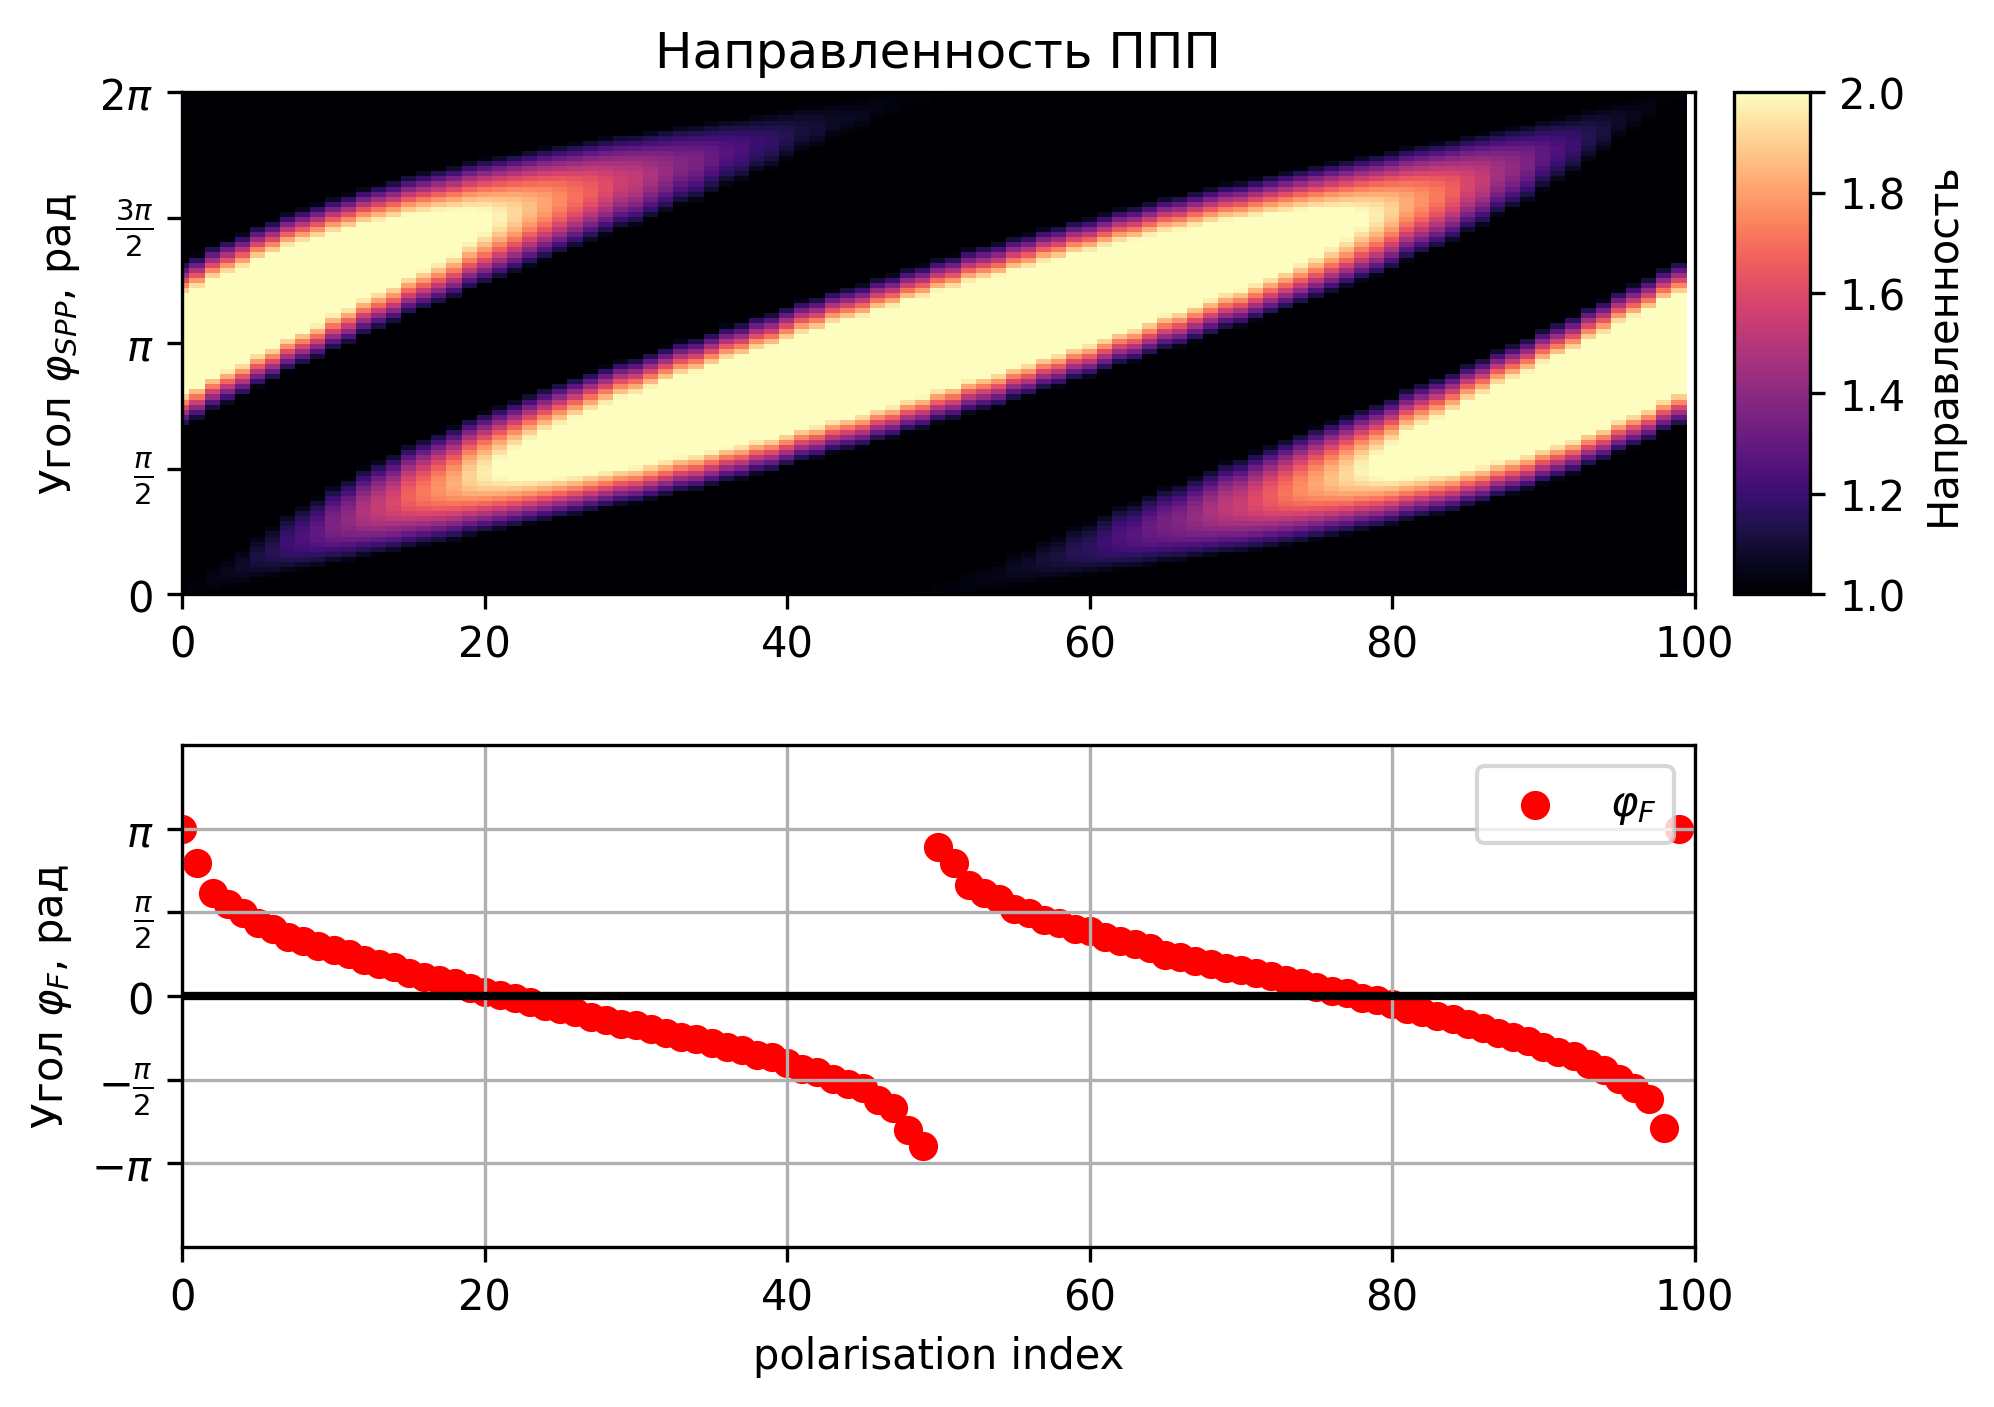

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(7, 5), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(range(len(best_params)), PHI, directivity_opt, cmap='magma', vmax=2, vmin=1)


# y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
# y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']

y_ticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
y_ticklabels = [ r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
ax_top.set_yticks(y_ticks)
ax_top.set_yticklabels(y_ticklabels)

ax_top.set_ylim(0, 2*np.pi)
ax_top.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_top.set_title('Направленность ППП')

# === Colorbar ===
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Направленность')

# === Нижний график (углы силы) ===
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)

angles_no_sc= np.arctan2(F_y_opt[:, 0], (F_x_opt[:, 0] - F_x_opt[:, 1] - F_x_opt[:, 4]))

angles_only_fpp = np.arctan2(F_y_opt[:, 2], F_x_opt[:, 2])
#angles_no_sc= np.unwrap(angles_only_fpp)


# Границы и метки оси Y
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_bottom.set_yticks(y_ticks)
ax_bottom.set_yticklabels(y_ticklabels)
ax_bottom.axhline(0, color='black', linestyle='-', linewidth=2)
# closest_to_zero_idx = np.argmin(np.abs(angles_no_sc_from_R))
# approx_zero_crossing_x = Rs[closest_to_zero_idx]
# ax_bottom.axvline(approx_zero_crossing_x, color='black', linestyle='--', linewidth=2)
ax_bottom.scatter(range(len(best_params)), angles_no_sc, label=r'$\varphi_F$', color='r', linewidth=1)
ax_bottom.set_ylim(-9*np.pi/6, 9*np.pi/6)
ax_bottom.set_xlim(0, len(best_params))
ax_bottom.set_xlabel('polarisation index')
ax_bottom.set_ylabel(r'Угол $\varphi_F$, рад')
ax_bottom.grid(True)
ax_bottom.legend()
# plt.savefig(f'spp_vs_f_nosc_from_wl_z0_{point[2]}_R_{R}_phase_{phase}.png', dpi=300)



In [286]:
phiii = np.empty(len(best_params))
for i in range(len(best_params)):
    j = np.argmax(directivity_opt[:,i])
    phiii[i] = PHI[j]


(0.0, 100.0)

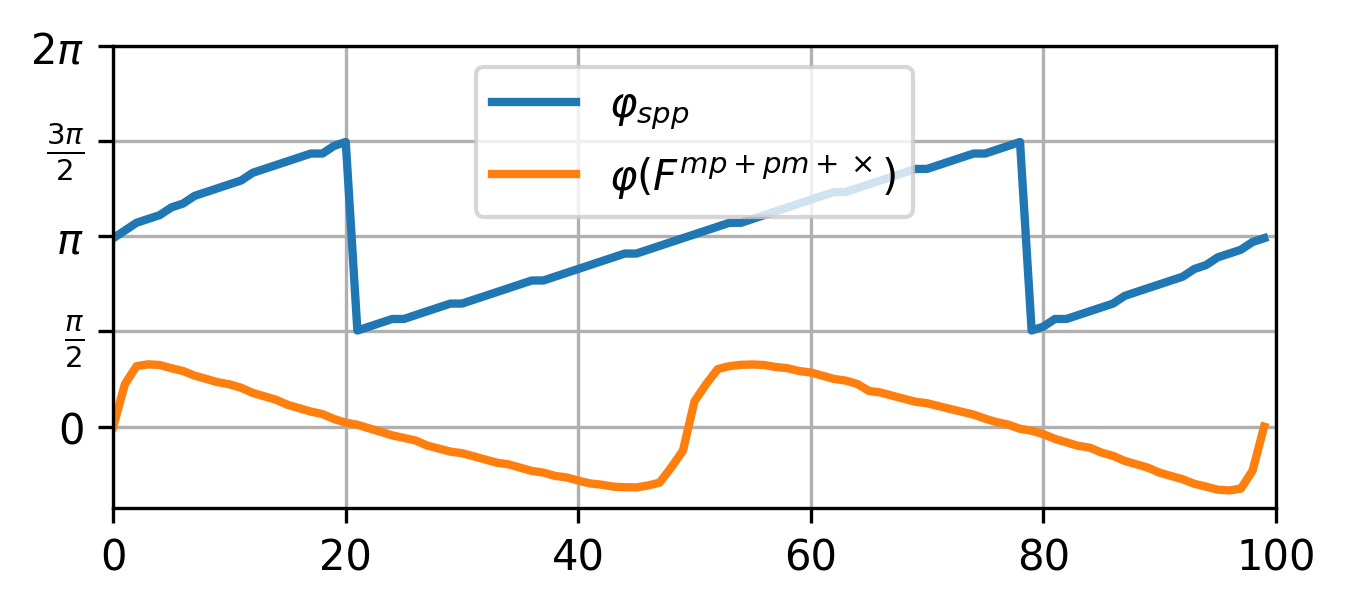

In [327]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(range(len(best_params)), phiii, label=r'$\varphi_{spp}$', lw=2)
plt.plot(range(len(best_params)), np.arctan2(F_y_opt[:,3]+F_y_opt[:,6]+F_y_opt[:,7], F_x_opt[:,3]+F_x_opt[:,6]+F_x_opt[:,7]), label=r'$\varphi (F^{mp+pm+\times})$', lw=2)
plt.grid()
plt.legend()
y_ticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
y_ticklabels = [ r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.yticks(y_ticks,y_ticklabels)

plt.xlim(0,len(best_params))

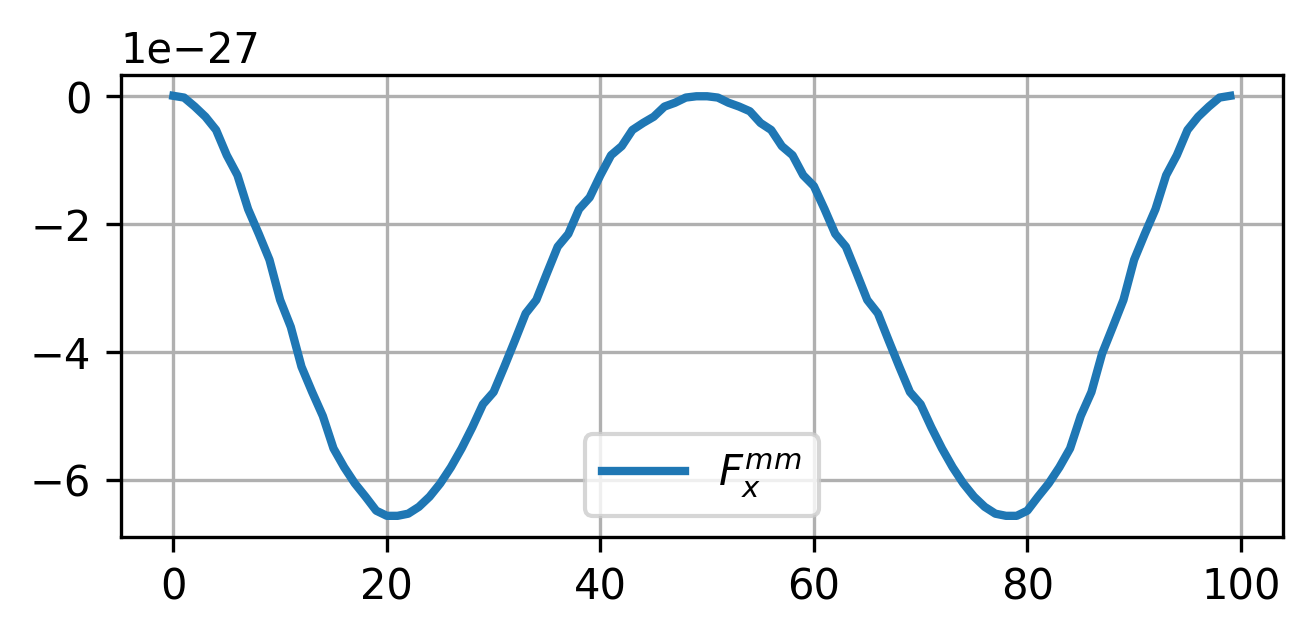

In [312]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(range(len(best_params)),  F_x_opt[:,5], label=r'$F_x^{mm}$', lw=2)
plt.grid()
plt.legend()


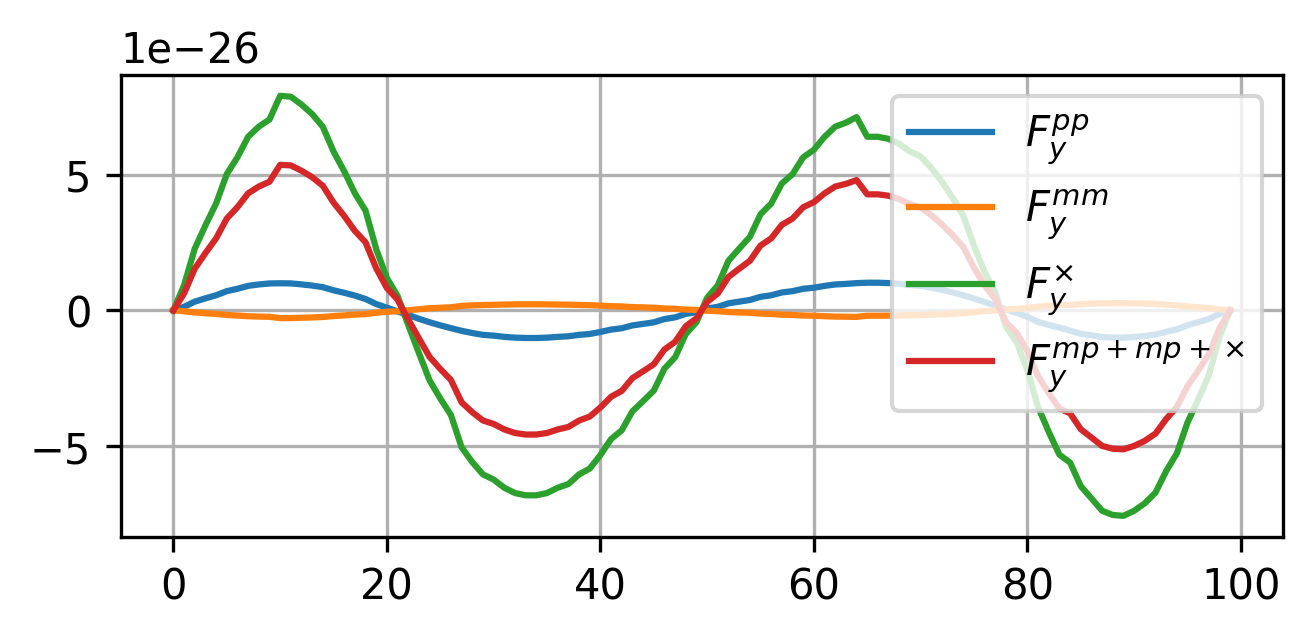

In [333]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(range(len(best_params)), F_y_opt[:,2], label=r'$F_y^{pp}$')
plt.plot(range(len(best_params)), F_y_opt[:,5], label=r'$F_y^{mm}$')
plt.plot(range(len(best_params)), F_y_opt[:,7], label=r'$F_y^{\times}$')
plt.plot(range(len(best_params)), F_y_opt[:,7]+F_y_opt[:,3]+F_y_opt[:,6], label=r'$F_y^{mp+mp+\times}$')
plt.grid()
plt.legend()

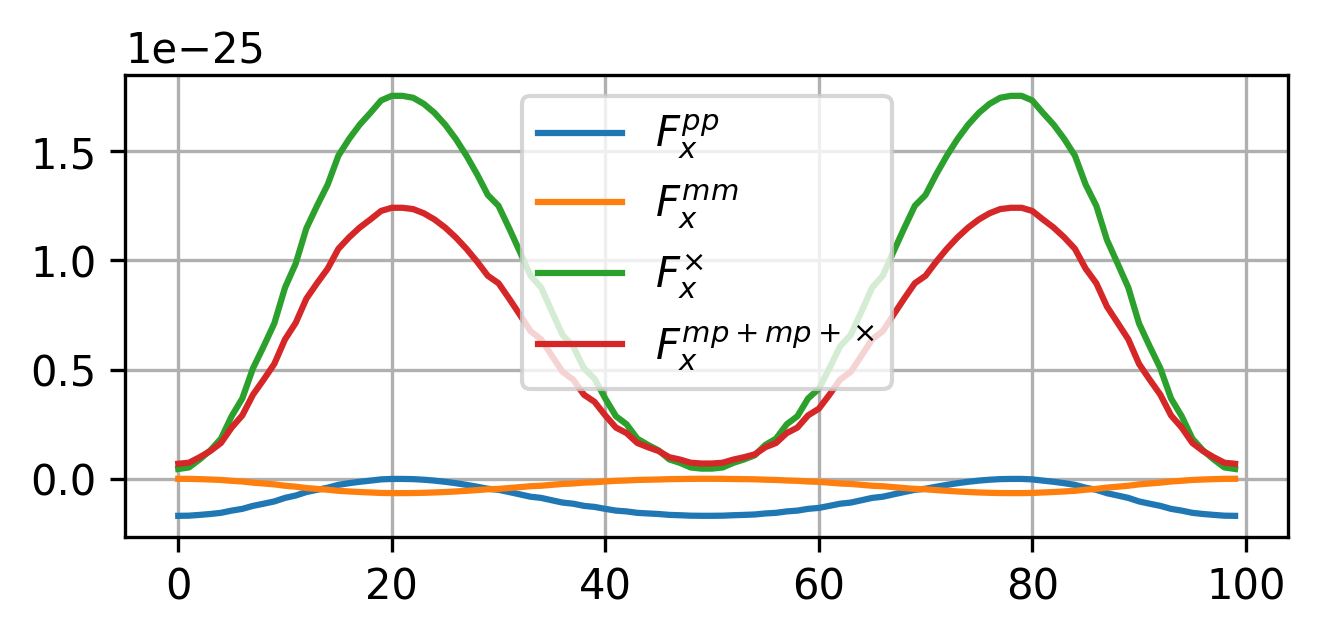

In [334]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(range(len(best_params)), F_x_opt[:,2], label=r'$F_x^{pp}$')
plt.plot(range(len(best_params)), F_x_opt[:,5], label=r'$F_x^{mm}$')
plt.plot(range(len(best_params)), F_x_opt[:,7], label=r'$F_x^{\times}$')
plt.plot(range(len(best_params)), F_x_opt[:,7]+F_x_opt[:,3]+F_x_opt[:,6], label=r'$F_x^{mp+mp+\times}$')
plt.grid()
plt.legend()

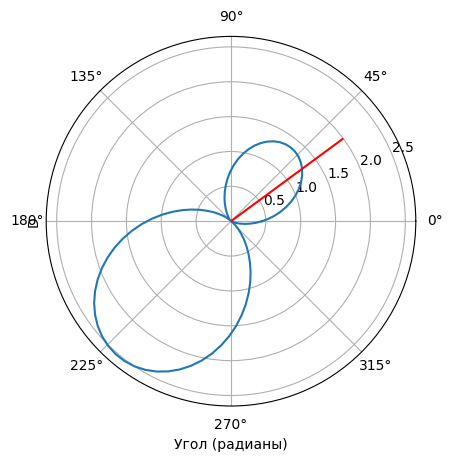

In [283]:
ind = 10


PHI_ind = np.linspace(0,2*np.pi, 100)


j = np.argmax(directivity_opt[ind,:])
phi_max = PHI[j]
    
D_ind = get_directivity(wl, dipoles_p[ind], dipoles_m[ind], eps_Au)
DIRS = D_ind(PHI_ind)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(PHI_ind, DIRS)
ax.vlines(phi_max, 0,2, color='red')
ax.grid(True)
plt.xlabel("Угол (радианы)")
plt.ylabel("D")
plt.show()


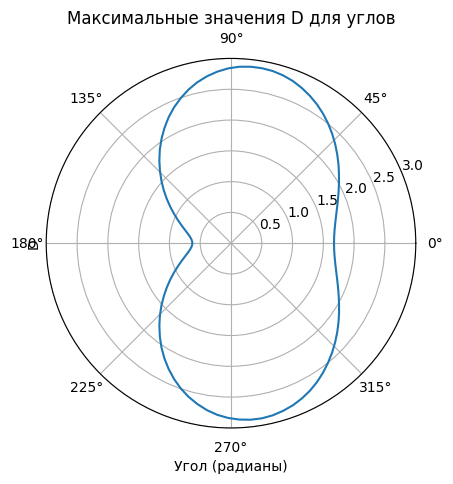

In [126]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, best_D)
ax.grid(True)
plt.xlabel("Угол (радианы)")
plt.ylabel("D")
ax.set_title("Максимальные значения D для углов")
plt.show()

In [16]:
sigma_sc = np.loadtxt("Dipoles_Analytical\sigma_tot.txt", skiprows=8, delimiter=',')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\borod\AppData\Local\Temp\ipykernel_7436\2075925555.py:1: SyntaxWarning: invalid escape sequence '\s'
  sigma_sc = np.loadtxt("Dipoles_Analytical\sigma_tot.txt", skiprows=8, delimiter=',')


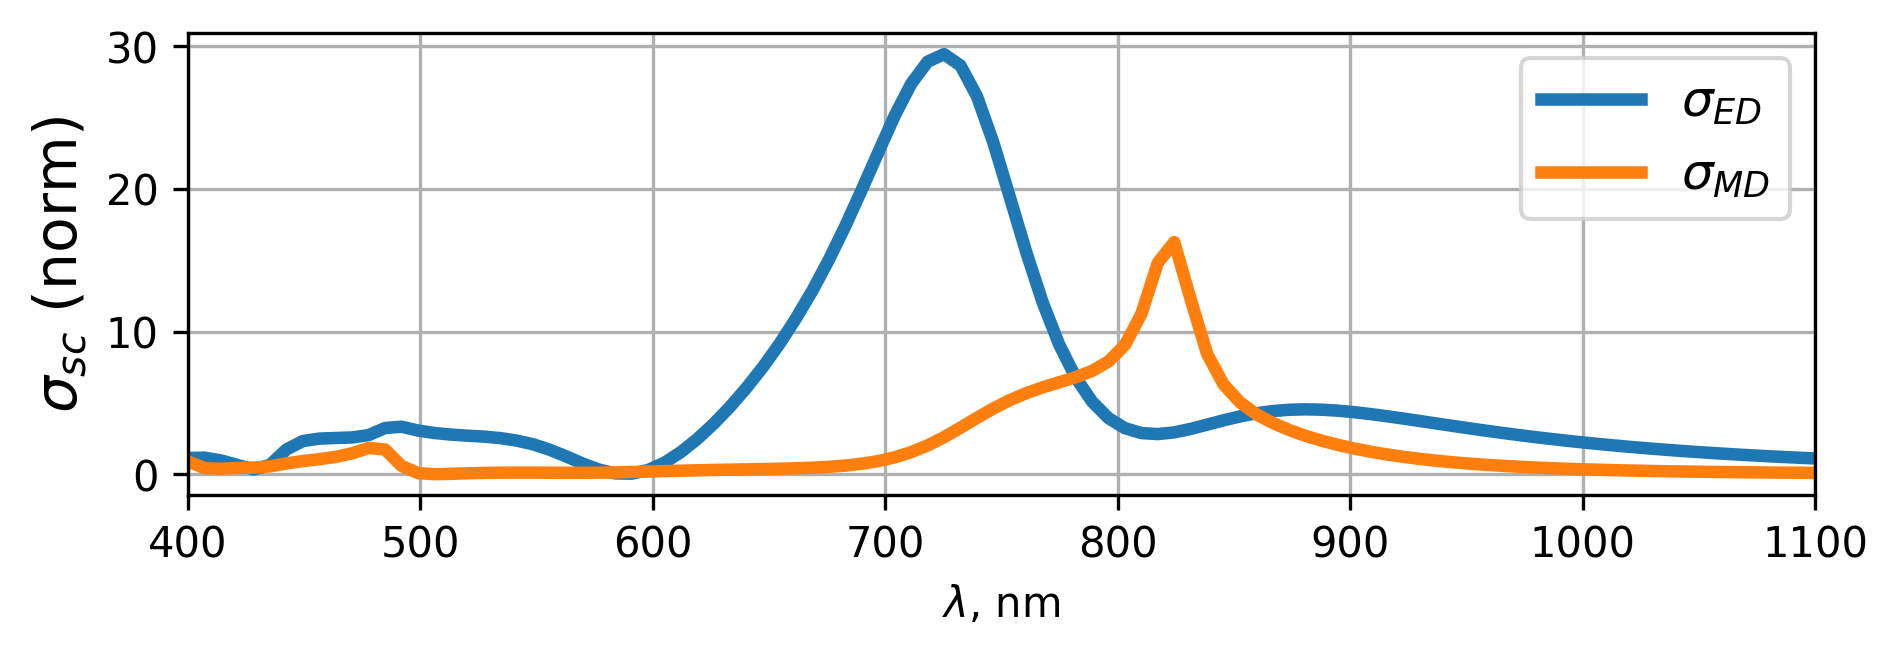

In [35]:
const_sigma_sc = k0(wls)**4/(6*np.pi*eps0_const**2)

ED = np.abs(P[:,0])**2+ np.abs(P[:,1])**2+np.abs(P[:,2])**2

MD = (np.abs(M[:,0])**2+ np.abs(M[:,1])**2+np.abs(M[:,2])**2)/c_const**2

sigma_ED = ED *const_sigma_sc
sigma_MD = MD * const_sigma_sc




fig, ax1 = plt.subplots(1, 1, figsize=(7, 2), dpi=300)

# Первый график: ED и MD

ax1.plot(wls, sigma_ED/(np.pi*(R*1e-9)**2), label='$\\sigma_{ED}$', lw=3)
ax1.plot(wls, sigma_MD/(np.pi*(R*1e-9)**2), label='$\\sigma_{MD}$', lw=3)


# ax1.plot(sigma_sc[:, 0], sigma_sc[:, 1], label='$\\sigma_{ED}$', linewidth=2, color='#1f77b4', ls='--')
# ax1.plot(sigma_sc[:, 0], sigma_sc[:, 2], label='$\\sigma_{MD}$', linewidth=2, color='#ff7f0e', ls='--')
ax1.set_ylabel('$\\sigma_{sc}$ (norm)', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('$\\lambda$, nm')

plt.xlim(wls[0], wls[-1])

plt.savefig(f'sigma_sc_from_wl_z0_{point[2]}.pdf', dpi=300)


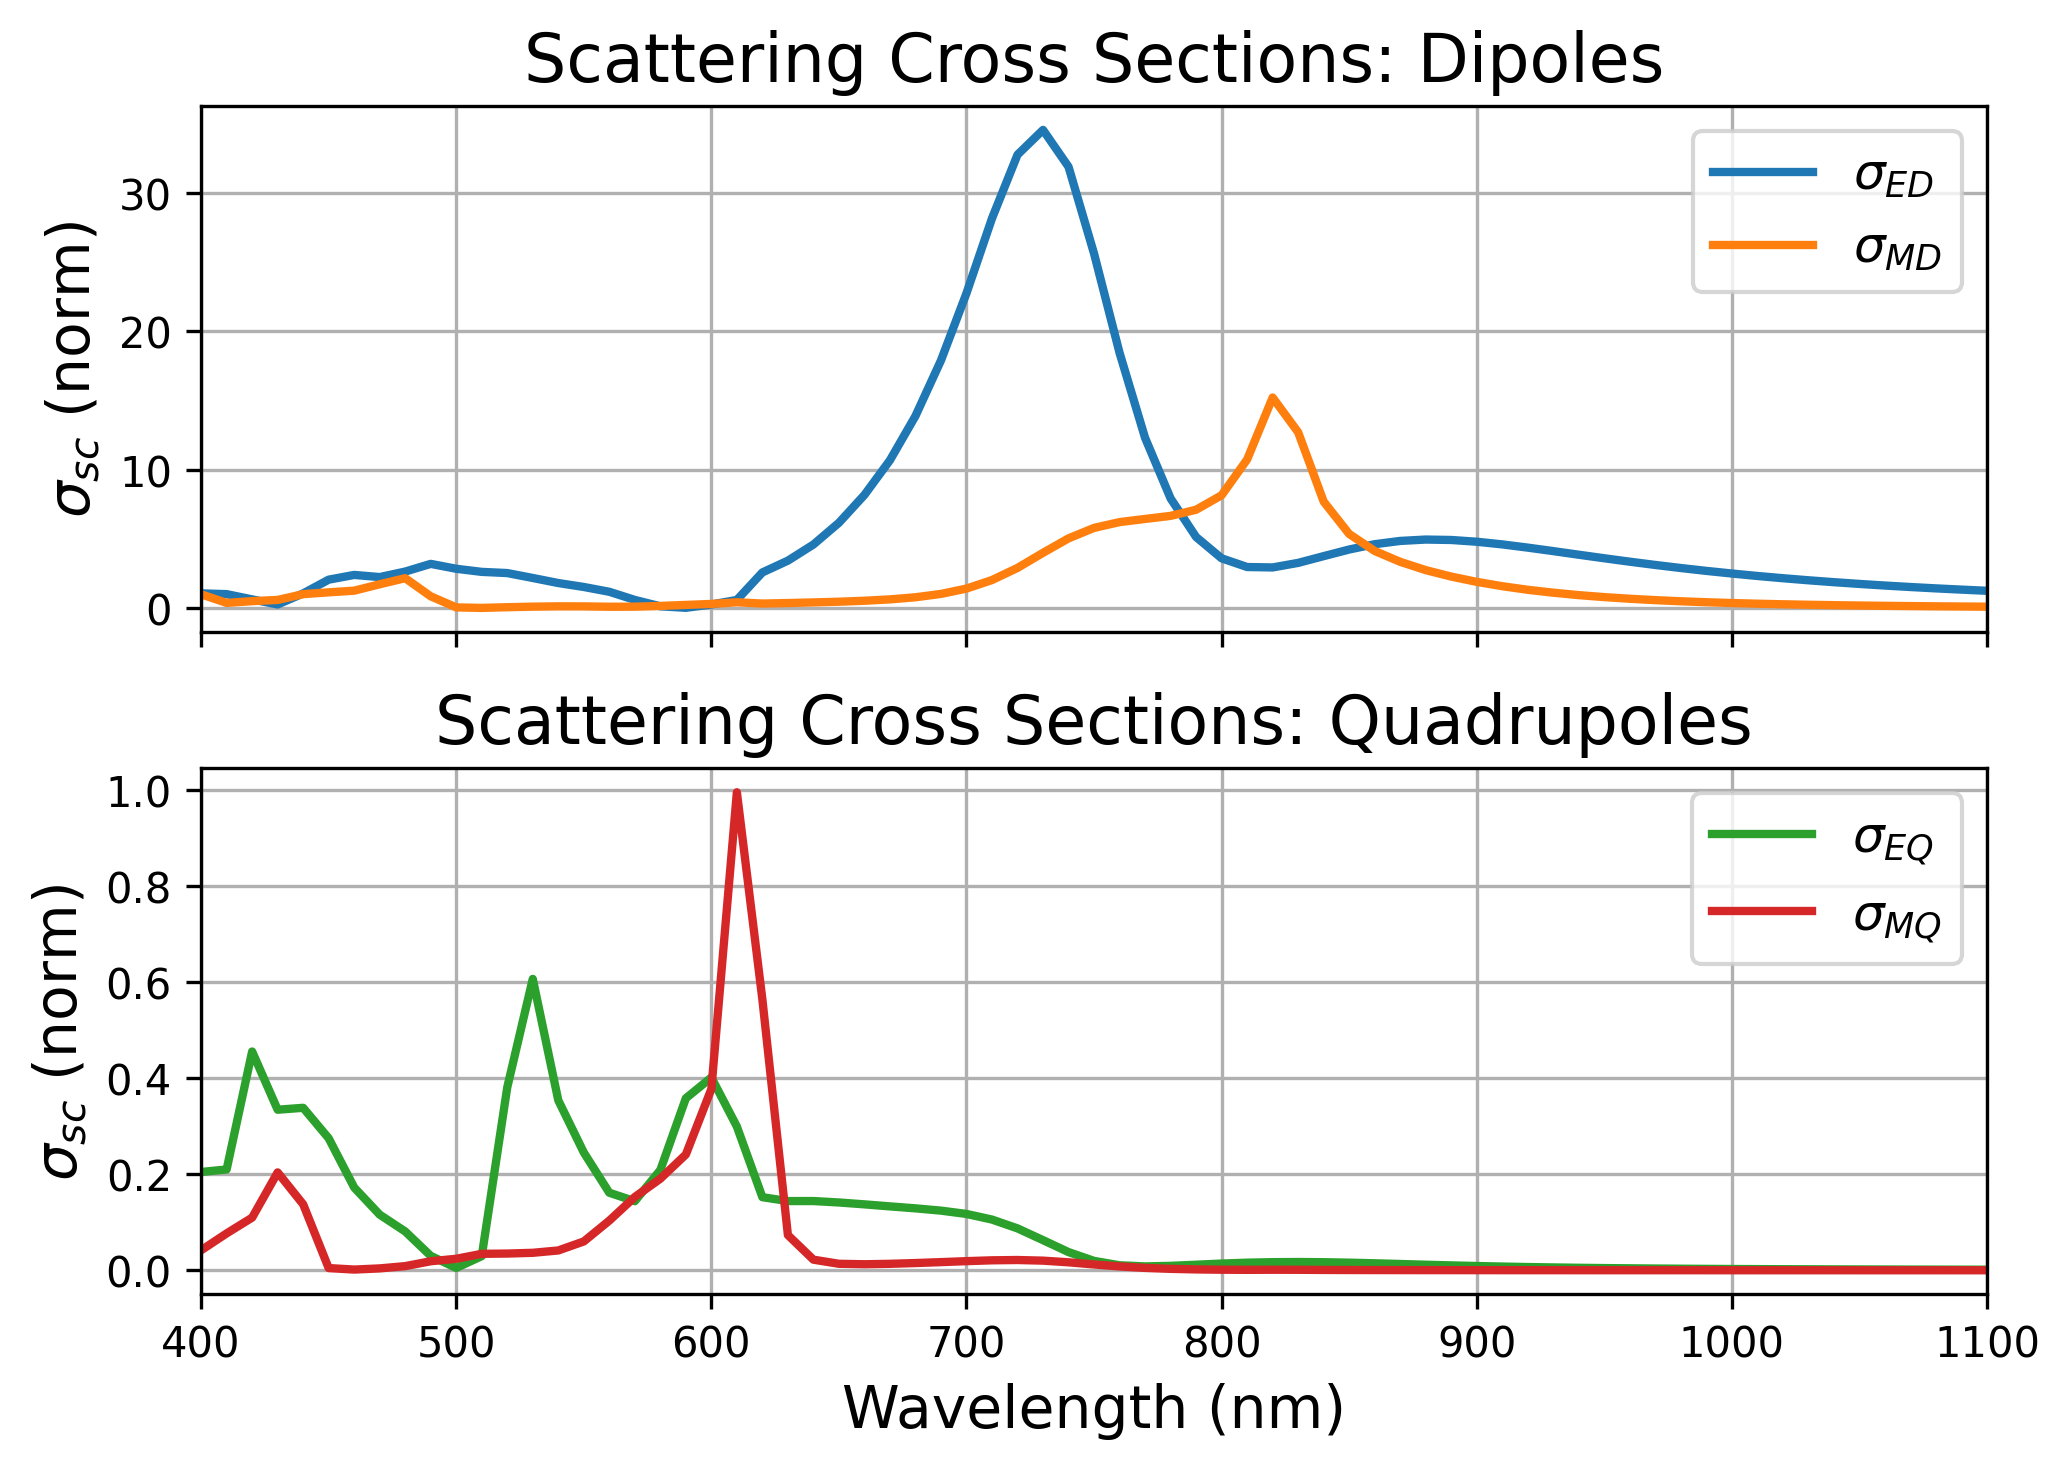

In [168]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True, dpi=300)

# Первый график: ED и MD
ax1.plot(sigma_sc[:, 0], sigma_sc[:, 1], label='$\\sigma_{ED}$', linewidth=2, color='#1f77b4')
ax1.plot(sigma_sc[:, 0], sigma_sc[:, 2], label='$\\sigma_{MD}$', linewidth=2, color='#ff7f0e')
ax1.set_ylabel('$\\sigma_{sc}$ (norm)', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_title('Scattering Cross Sections: Dipoles', fontsize=16)

plt.xlim(sigma_sc[0, 0], sigma_sc[-1, 0])

# Второй график: EQ и MQ
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 3], label='$\\sigma_{EQ}$', linewidth=2, color='#2ca02c')
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 4], label='$\\sigma_{MQ}$', linewidth=2, color='#d62728')
ax2.set_xlabel('Wavelength (nm)', fontsize=14)
ax2.set_ylabel('$\\sigma_{sc}$ (norm)', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=12)
ax2.set_title('Scattering Cross Sections: Quadrupoles', fontsize=16)

plt.tight_layout()
plt.savefig('scattering_cross_sections_from_wl.pdf', dpi=300)
plt.show()


In [4]:
Rs = np.linspace(60, 160, 100)
wl = 800
STOP = 45
angle = 25*np.pi/180
dist = 2
a_angle = np.pi/4

phase = -np.pi/2

F_x_from_R = np.empty((len(Rs), 8))
F_y_from_R = np.empty_like(F_x_from_R)
F_z_from_R = np.empty_like(F_x_from_R)

P_from_R,M_from_R = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)


for i in tqdm(range(len(Rs))):
    point = [0,0,dist+Rs[i]]
    f =  force.F(wl, eps_Au, point, Rs[i], eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x_from_R[i,:] = f[0]
    F_y_from_R[i,:] = f[1]
    F_z_from_R[i,:] = f[2]
    p,m = dipoles.calc_dipoles_v2(wl, eps_Au, point, Rs[i], eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    p,m = p[:,0],m[:,0]
    P_from_R[i,:],M_from_R[i,:]=p,m
    
    

PHI = np.linspace(-np.pi, np.pi, 100)

directivityR = np.empty((len(PHI), len(Rs)))
for R_idx, R_i in enumerate(Rs):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, P_from_R[R_idx,:], M_from_R[R_idx,:], eps_Au)
        directivityR[angle_idx, R_idx] = D(PHI[angle_idx])

        

 18%|█▊        | 18/100 [00:41<03:06,  2.28s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:441: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
 60%|██████    | 60/100 [02:31<01:49,  2.73s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
100%|██████████| 100/100 [04:20<00:00,  2.60s/it]


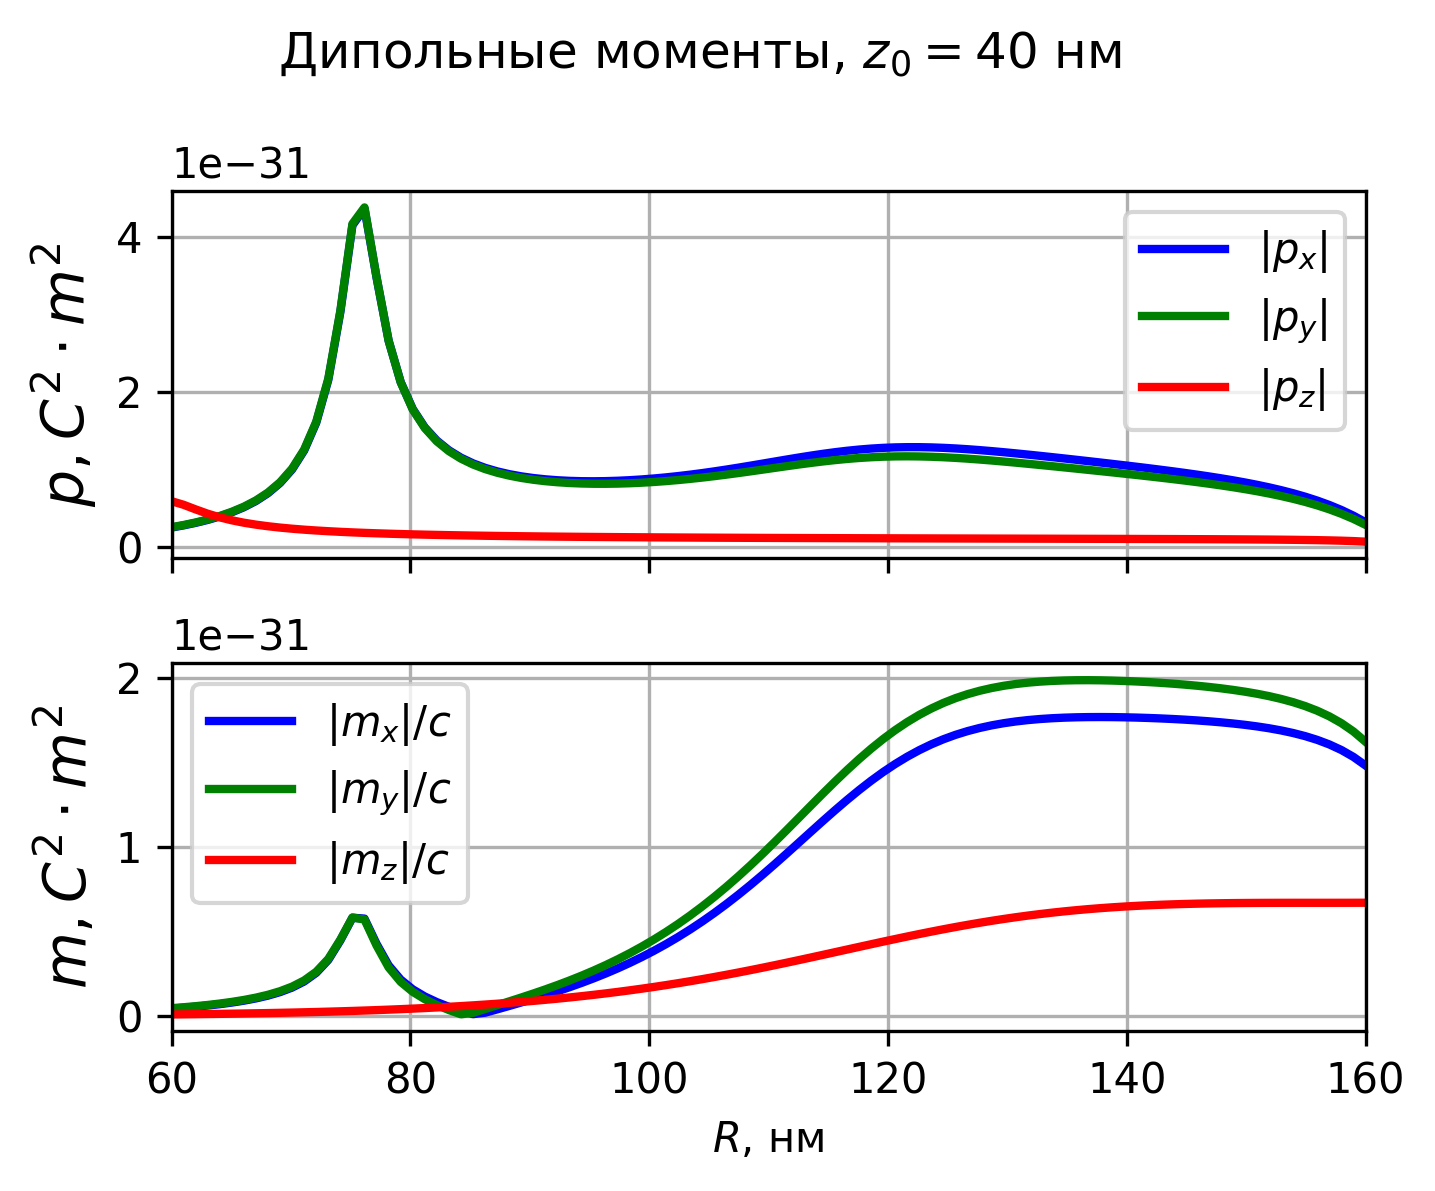

In [163]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(5, 4), sharex=True, dpi=300)

ax1.plot(Rs, np.abs(P_from_R[:,0]), label='|$p_x|$', color='blue', lw=2)
ax1.plot(Rs, np.abs(P_from_R[:,1]), label='$|p_y|$', color='green', lw=2)   
ax1.plot(Rs, np.abs(P_from_R[:,2]), label='$|p_z|$', color='red', lw=2)

ax2.plot(Rs, np.abs(M_from_R[:,0])/c_const, label='$|m_x|/c$', color='blue', lw=2)
ax2.plot(Rs, np.abs(M_from_R[:,1])/c_const, label='$|m_y|/c$', color='green', lw=2)   
ax2.plot(Rs, np.abs(M_from_R[:,2])/c_const, label='$|m_z|/c$', color='red', lw=2)


ax1.set_ylabel('$p, C^2 \\cdot m^2$', fontsize=14)
ax1.grid(True)
ax1.legend()
plt.suptitle(f'Дипольные моменты, $z_0=${dist} нм')


ax2.set_ylabel('$m, C^2 \\cdot m^2$', fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.set_xlabel('$R$, нм')

plt.xlim(Rs[0], Rs[-1])


plt.tight_layout()
plt.savefig(f'p_m_from_R_z0_{dist}_wl_{wl}_a_{round(a_angle,2)}_phase_{round(phase,2)}.pdf', dpi=300)
plt.show()

In [17]:
sigma_sc = np.loadtxt('comsol data\\sigma-r.txt', skiprows=8, delimiter=',')
force_comsol = np.loadtxt('comsol data\\force-r.txt', skiprows=8, delimiter=',')

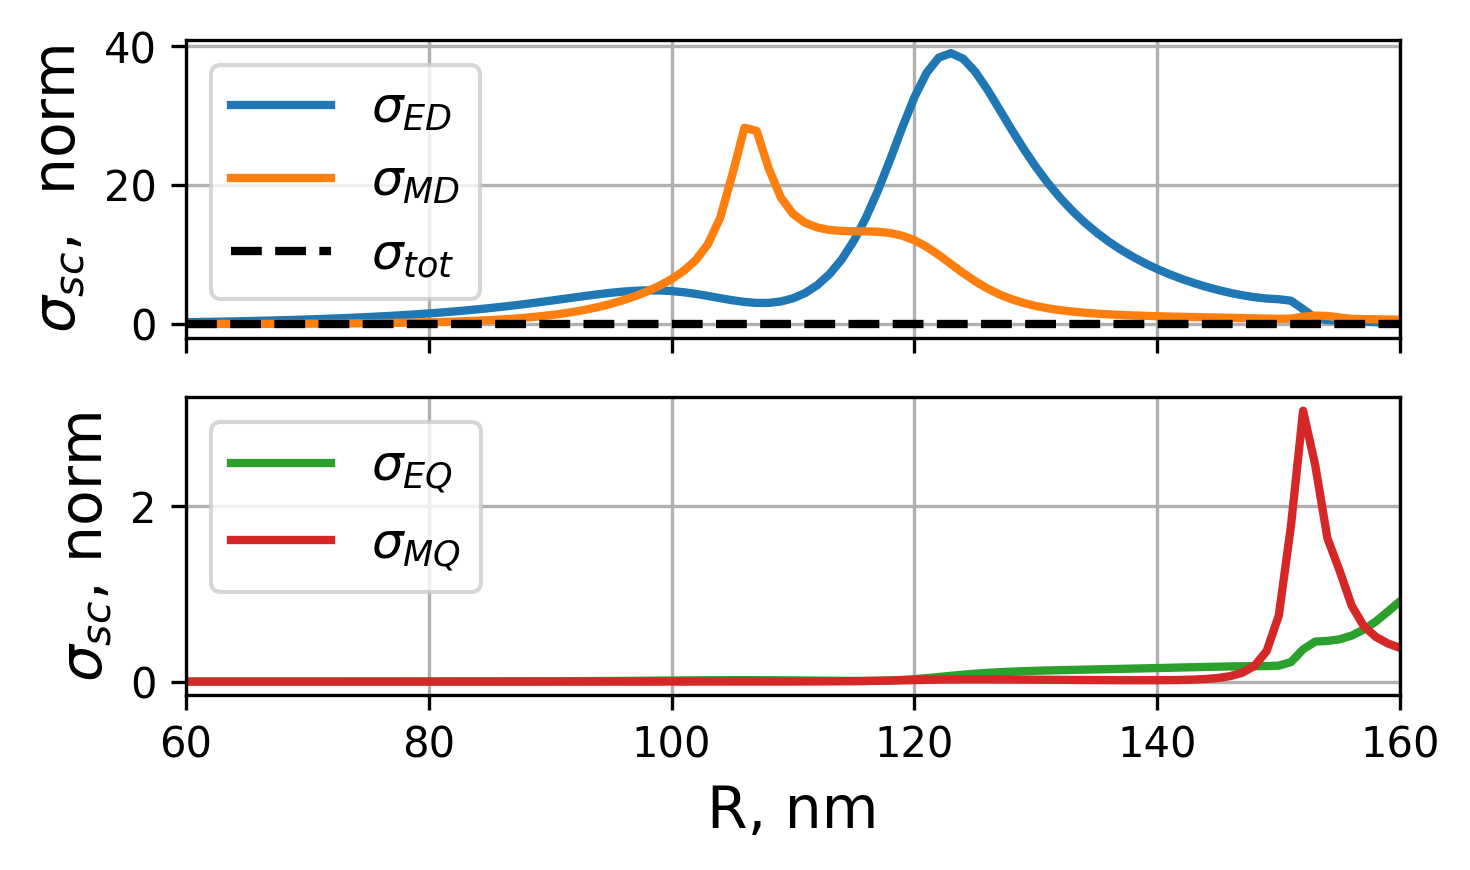

In [ ]:

fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(5, 3), sharex=True, dpi=300)

# Первый график: ED и MD
ax1.plot(sigma_sc[:, 0], sigma_sc[:, 1]/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{ED}$', linewidth=2, color='#1f77b4')
ax1.plot(sigma_sc[:, 0], 2*sigma_sc[:, 2]/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{MD}$', linewidth=2, color='#ff7f0e')
ax1.plot(sigma_sc[:, 0], (sigma_sc[:, 1]+2*sigma_sc[:, 2])/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{tot}$', linewidth=2, color='black', ls='--')
ax1.set_ylabel('$\\sigma_{sc}$,  norm', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
# ax1.set_xlabel('R, нм')

plt.xlim(sigma_sc[0, 0], sigma_sc[-1, 0])

# Второй график: EQ и MQ
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 3]/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{EQ}$', linewidth=2, color='#2ca02c')
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 4]/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{MQ}$', linewidth=2, color='#d62728')
ax2.set_xlabel('R, nm', fontsize=14)
ax2.set_ylabel('$\\sigma_{sc}$, norm', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.savefig('scattering_cross_sections_from_R.png', dpi=300)
plt.show()


In [7]:
fmax = 0
for i in range(len(Rs)):
    f0 = force.F(wl, 1, [0,0,0], Rs[i], eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
    f0 = np.abs(f0)
    if f0 > fmax:
        fmax = f0
  

NameError: name 'force_comsol' is not defined

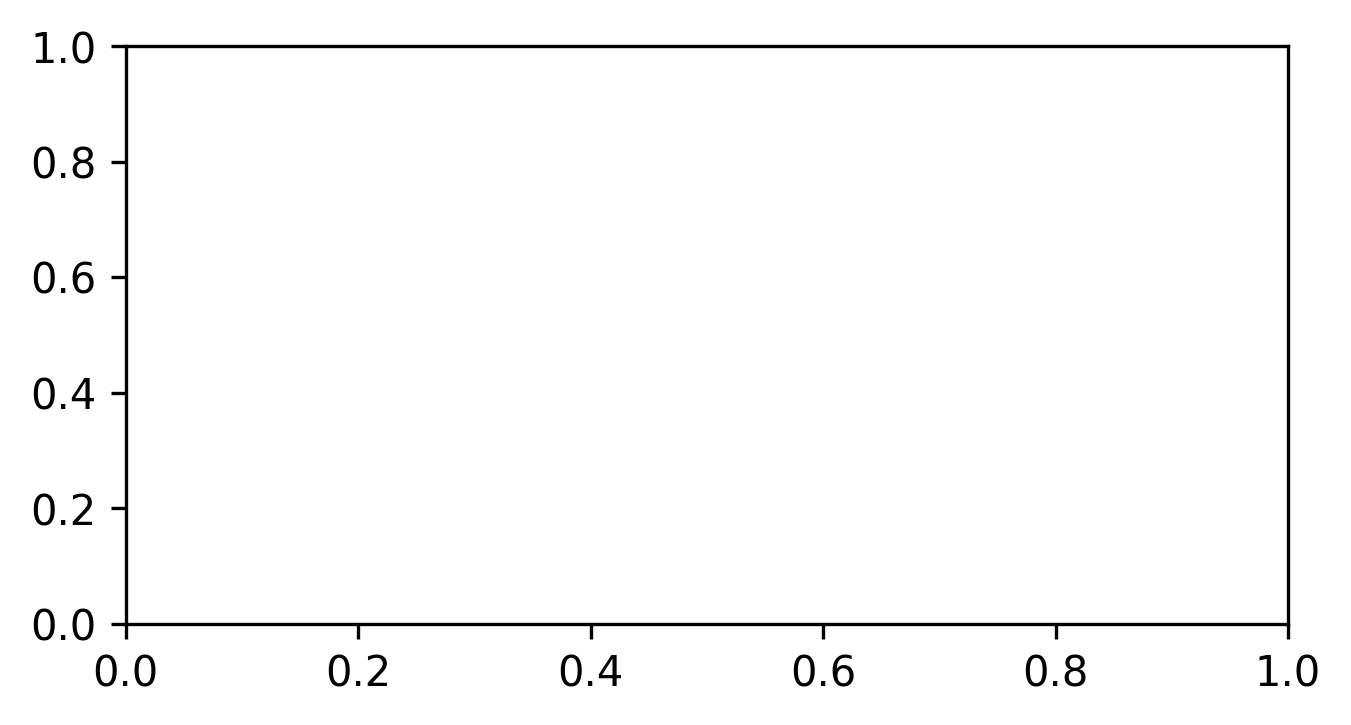

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2.5), sharex=True, dpi=300)

# Первый график: ED и MD
ax1.plot(force_comsol[:, 0], force_comsol[:, 1]/fmax, label='$F_x^{COMSOL}$', linewidth=2, color='#1f77b4')
ax1.plot(Rs, F_x_from_R[:,0]/fmax, label='$F_x^{Theory}$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel('$F/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('R, нм')

plt.xlim(Rs[0], Rs[-1])

plt.tight_layout()
plt.savefig('force_comsol_theory.pdf', dpi=300)
plt.show()


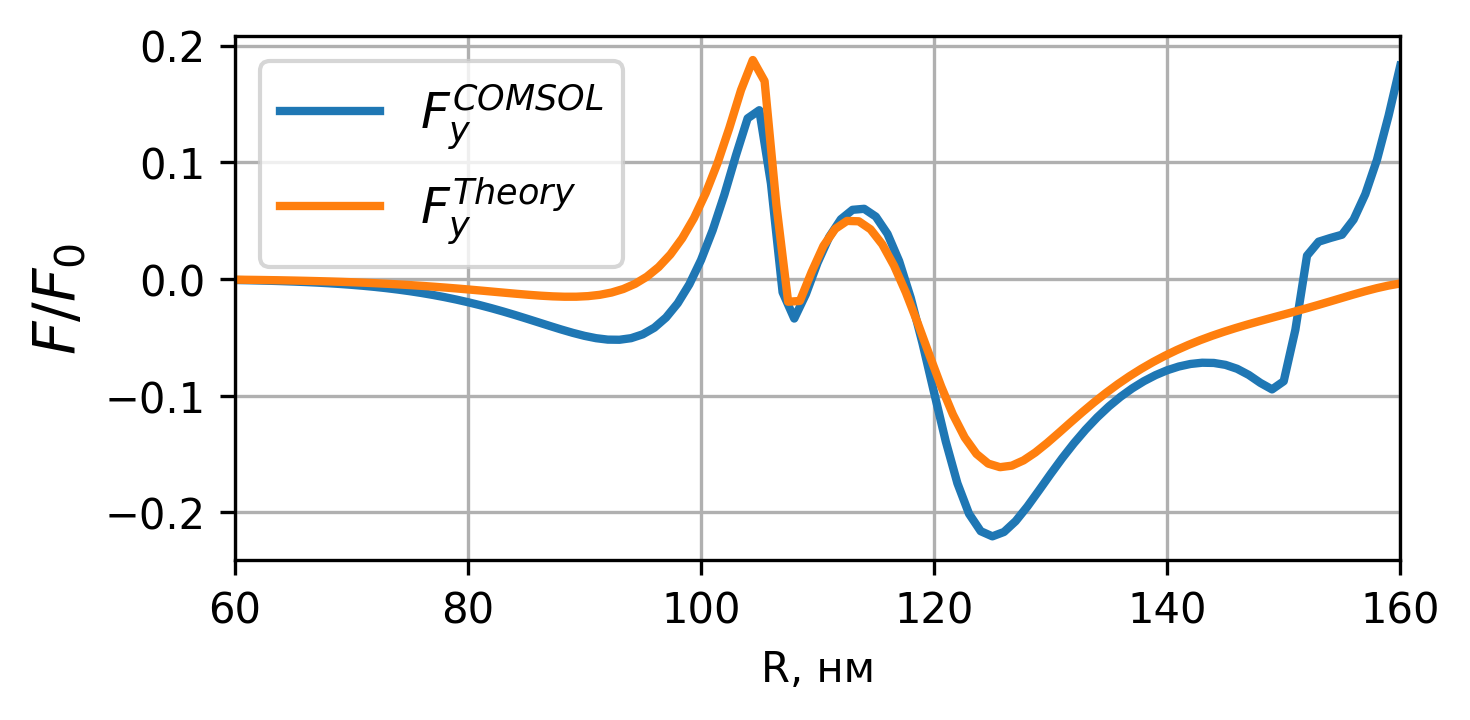

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2.5), sharex=True, dpi=300)

# Первый график: ED и MD
ax1.plot(force_comsol[:, 0], force_comsol[:, 2]/fmax, label='$F_y^{COMSOL}$', linewidth=2, color='#1f77b4')
ax1.plot(Rs, F_y_from_R[:,0]/fmax, label='$F_y^{Theory}$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel('$F/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('R, нм')

plt.xlim(Rs[0], Rs[-1])

plt.tight_layout()
plt.savefig('force_comsol_theory_y.pdf', dpi=300)
plt.show()


In [164]:
phi_D_fromR = np.empty(len(Rs))
for i in range(len(Rs)):
    j = np.argmax(directivityR[:,i])
    phi_D_fromR[i] = PHI[j]

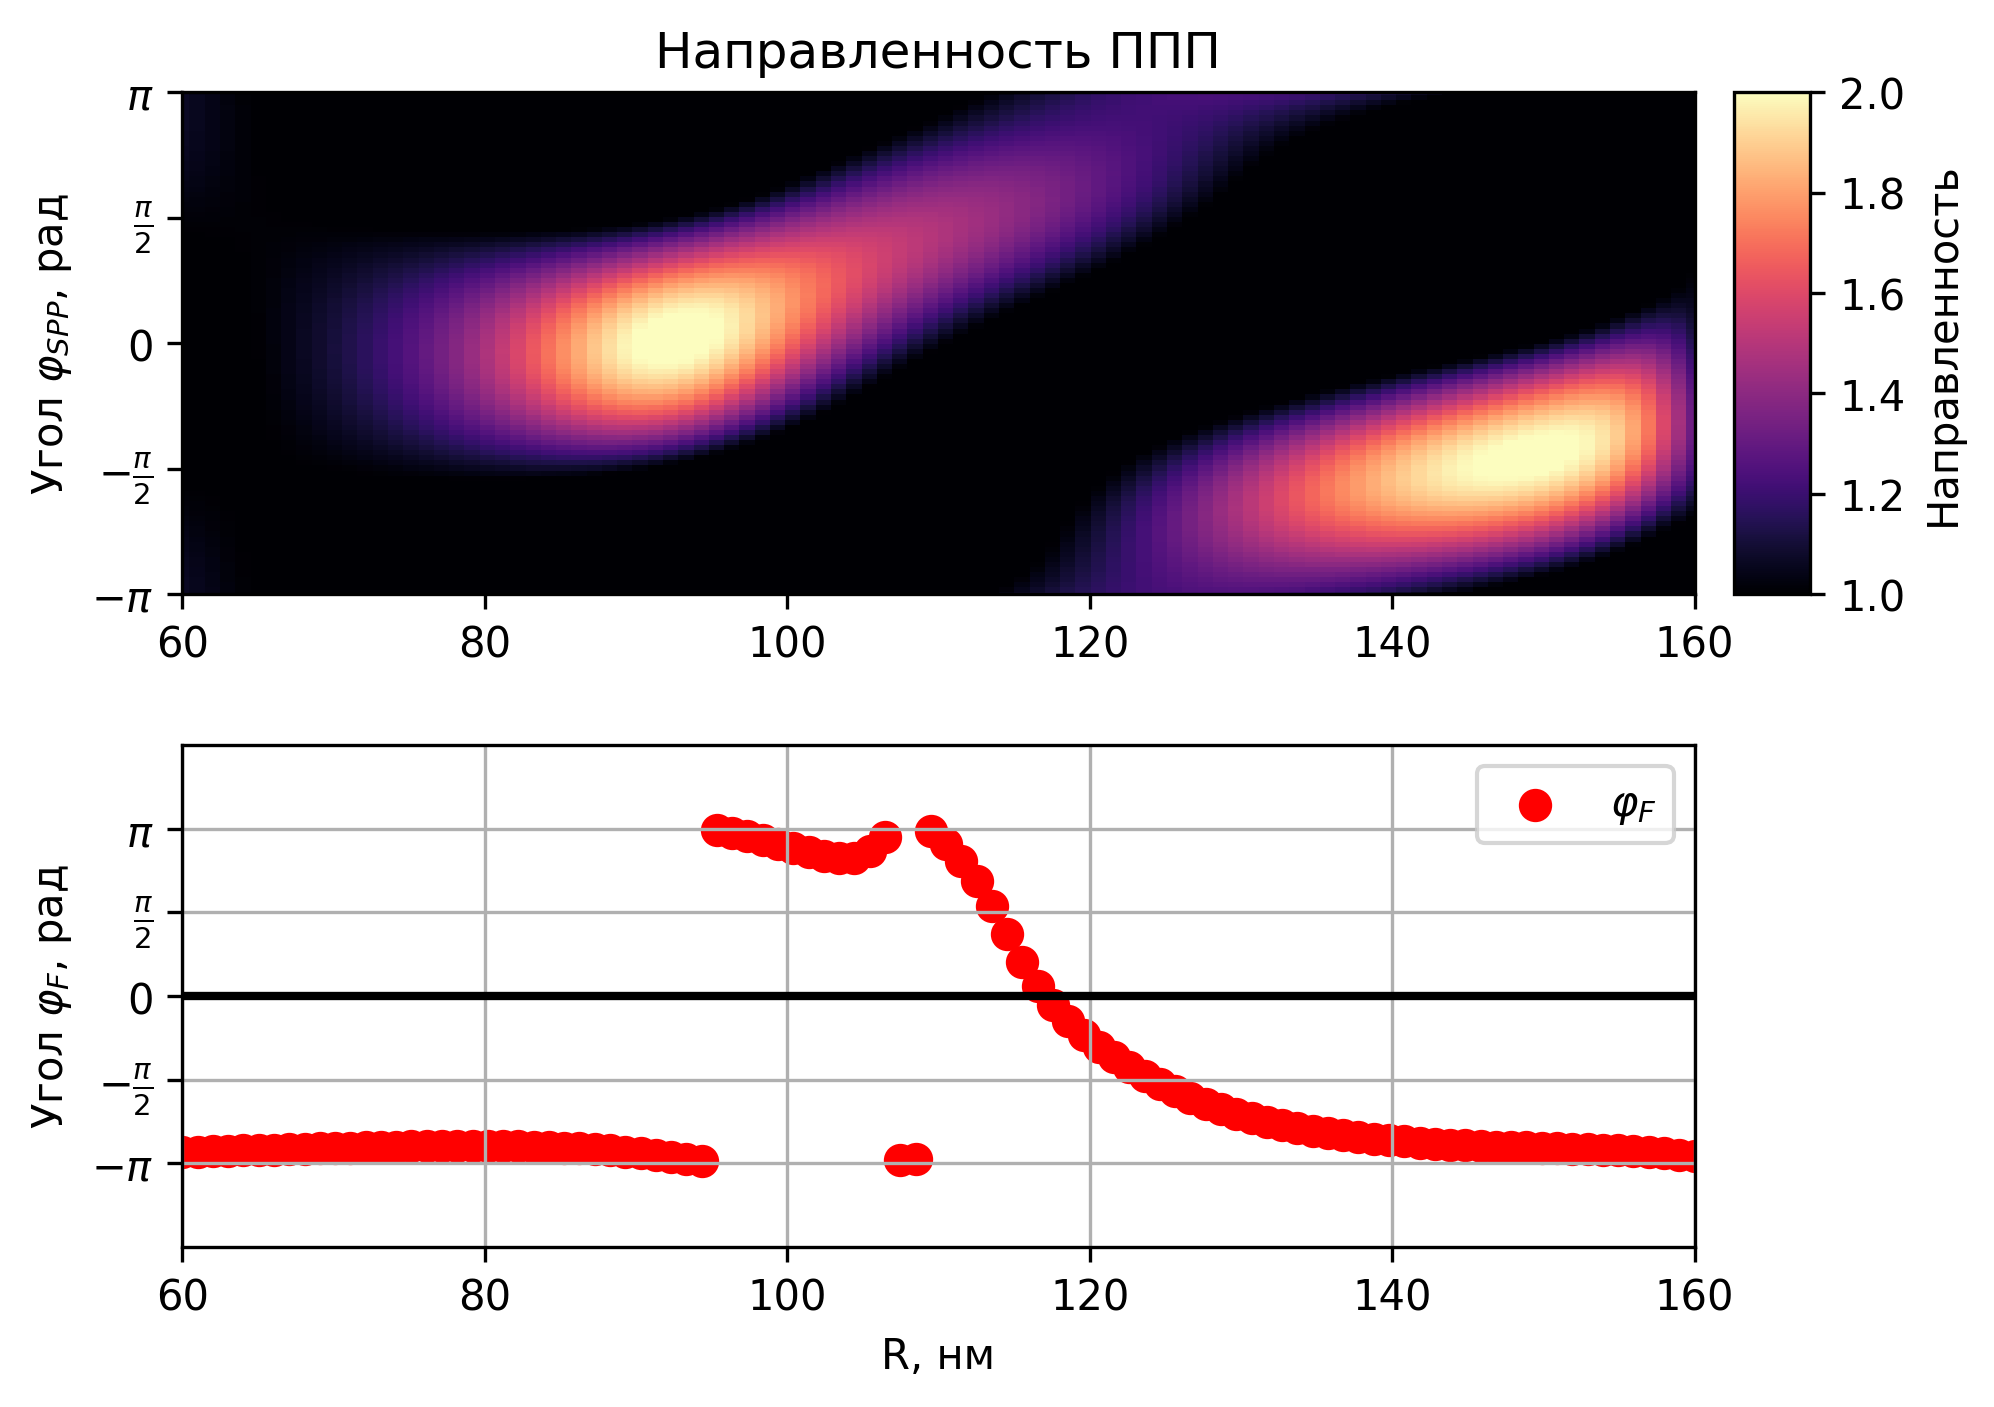

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# === Создание фигуры и макета ===
fig = plt.figure(figsize=(7, 5), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# === Верхний график (тепловая карта) ===
ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(Rs, PHI, directivityR, cmap='magma', vmax=2, vmin=1)

# Настройка оси Y: метки углов в виде кратных π
# y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
# y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_top.set_yticks(y_ticks)
ax_top.set_yticklabels(y_ticklabels)

ax_top.set_ylim(-np.pi, np.pi)
ax_top.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_top.set_title('Направленность ППП')

# === Colorbar ===
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Направленность')

# === Нижний график (углы силы) ===
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)

angles_no_sc_from_R = np.arctan2(F_y_from_R[:, 0], F_x_from_R[:, 0] - F_x_from_R[:, 1] - F_x_from_R[:, 4])
#angles_no_sc_from_R = np.unwrap(angles_no_sc_from_R)




y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_bottom.set_yticks(y_ticks)
ax_bottom.set_yticklabels(y_ticklabels)
ax_bottom.axhline(0, color='black', linestyle='-', linewidth=2)
# closest_to_zero_idx = np.argmin(np.abs(angles_no_sc_from_R+2*np.pi))
# approx_zero_crossing_x = Rs[closest_to_zero_idx]
# ax_bottom.axvline(approx_zero_crossing_x, color='black', linestyle='--', linewidth=2)
ax_bottom.scatter(Rs, angles_no_sc_from_R, label=r'$\varphi_F$', color='r', linewidth=2)
ax_bottom.set_ylim(-9*np.pi/6, 9*np.pi/6)
ax_bottom.set_xlim(Rs[0], Rs[-1])
ax_bottom.set_xlabel('R, нм')
ax_bottom.set_ylabel(r'Угол $\varphi_F$, рад')
ax_bottom.grid(True)
ax_bottom.legend()
#plt.savefig(f'spp_vs_f_nosc_from_R_z0_{dist}.png', dpi=300)



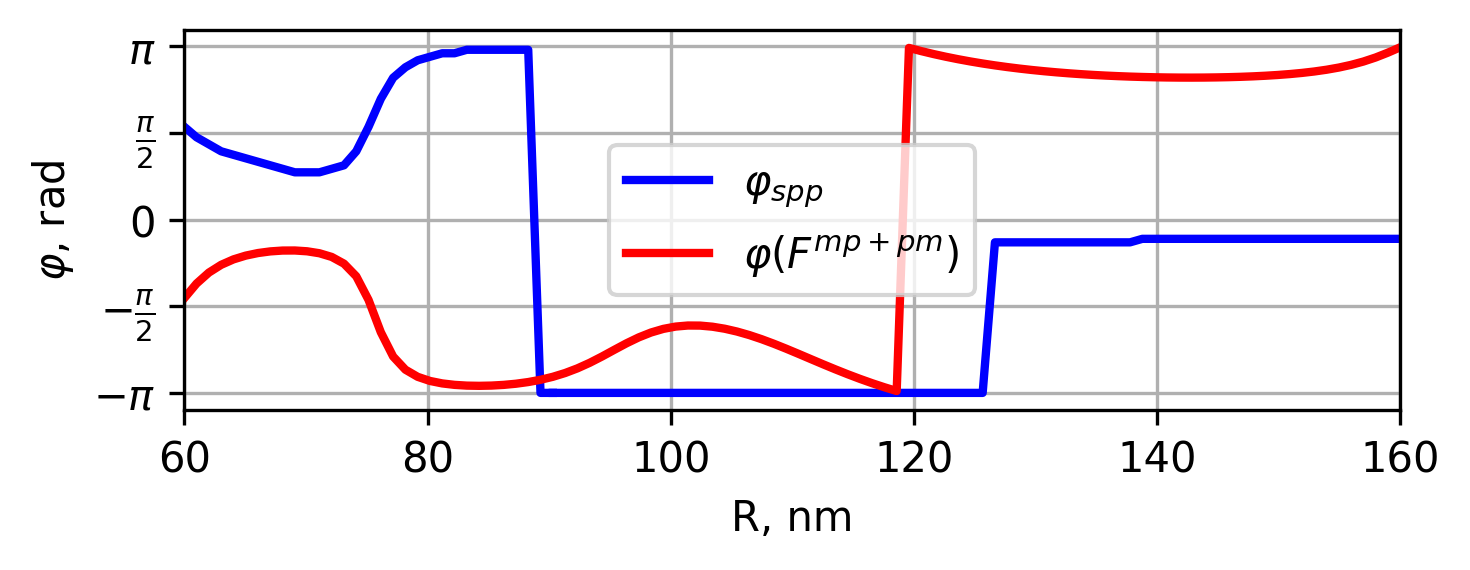

In [228]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(Rs[:31], phi_D_fromR[:31], label=r'$\varphi_{spp}$', c='blue', lw=2)
plt.plot(Rs[30:], np.unwrap(phi_D_fromR[30:]), c='blue', lw=2)
#plt.plot(Rs, angles_no_sc_from_R, label=r'$\varphi (F^{no\;sc})$', lw=2, c='r')
plt.plot(Rs, np.arctan2(F_y_from_R[:,3]+F_y_from_R[:,6], F_x_from_R[:,3]+F_x_from_R[:,6]), label=r'$\varphi (F^{mp+pm})$', lw=2, c='r')

plt.grid()
plt.legend()
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$',r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(y_ticks,y_ticklabels)
plt.xlim(Rs[0],Rs[-1])
plt.ylabel('$\\varphi$, rad')
plt.xlabel('R, nm')
plt.tight_layout()
#plt.savefig(f'spp_vs_f_nosc_from_R_z0_{dist}_angle_plot.png', dpi=300)
plt.show()

(60.0, 160.0)

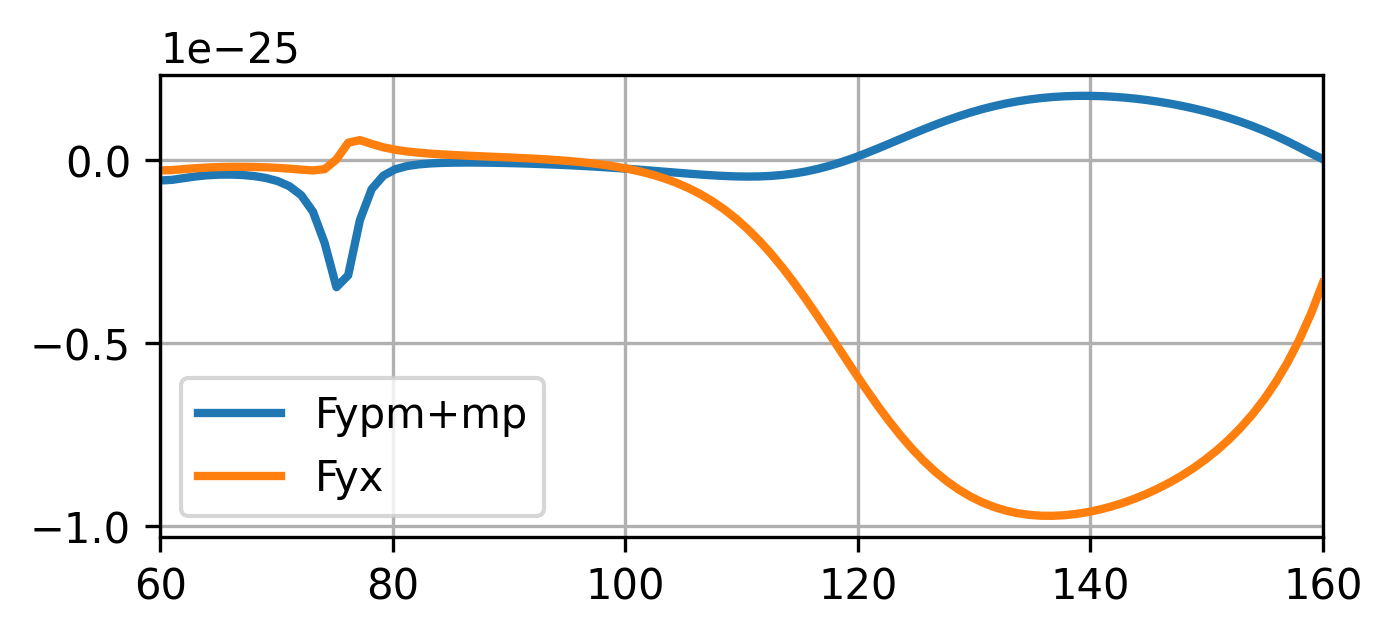

In [230]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(Rs, F_y_from_R[:,6]+ F_y_from_R[:,3], lw=2, label='Fypm+mp')
plt.plot(Rs, F_y_from_R[:,7], lw=2, label='Fyx')
plt.grid()
plt.legend()
plt.xlim(Rs[0],Rs[-1])

(60.0, 160.0)

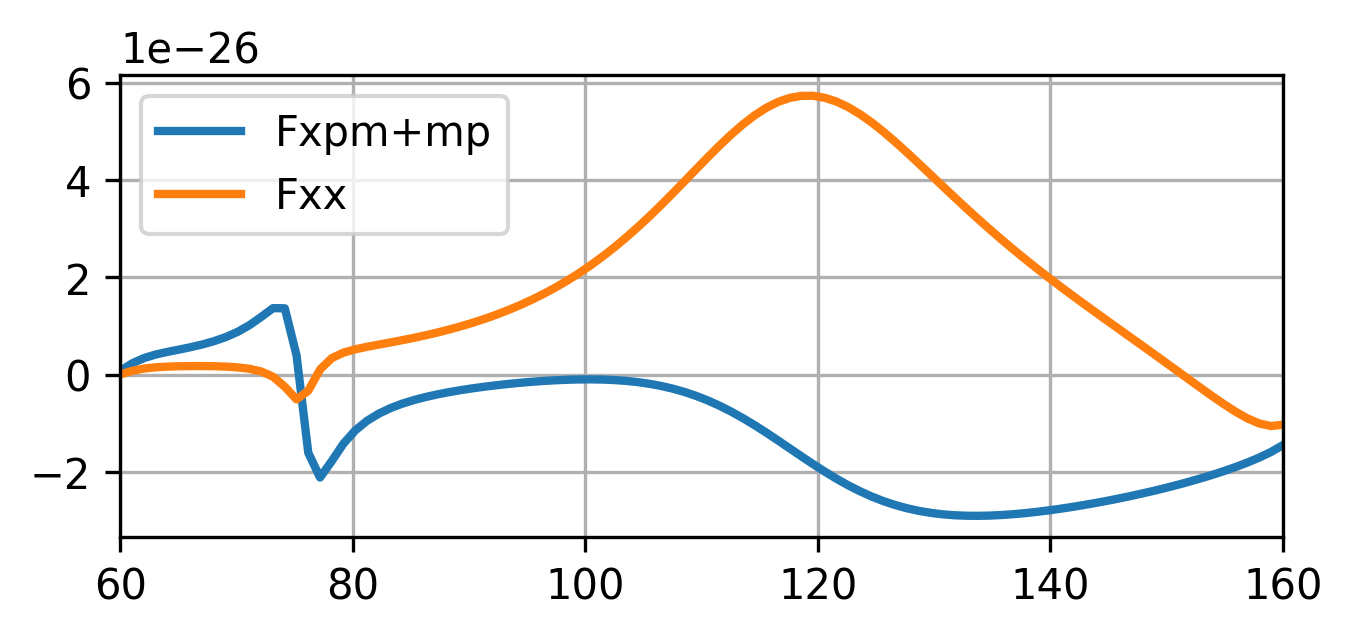

In [229]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(Rs, F_x_from_R[:,6]+ F_x_from_R[:,3], lw=2, label='Fxpm+mp')
plt.plot(Rs, F_x_from_R[:,7], lw=2, label='Fxx')
plt.grid()
plt.legend()
plt.xlim(Rs[0],Rs[-1])

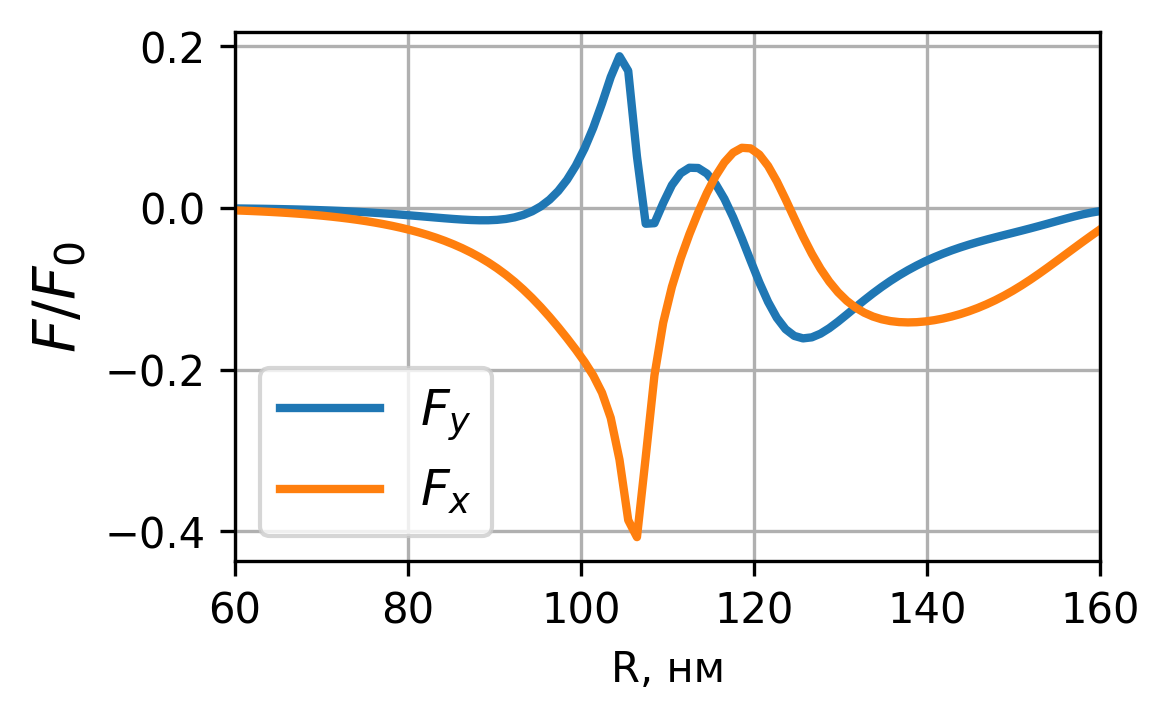

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize=(4, 2.5), sharex=True, dpi=300)


ax1.plot(Rs, (F_y_from_R[:,0])/fmax_Rs, label='$F_y$', linewidth=2, color='#1f77b4')
ax1.plot(Rs, (F_x_from_R[:,0]-(F_x_from_R[:,1]+F_x_from_R[:,4]))/fmax_Rs, label='$F_x$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel('$F/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('R, нм')

plt.xlim(Rs[0], Rs[-1])
plt.tight_layout()

plt.savefig(f'f_nosc_from_R_z0_{dist}.png', dpi=300)
plt.show()


In [6]:
fmax_Rs = 0
for i in range(len(Rs)):
    f0 = force.F(wl, 1, [0,0,0], Rs[i], eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
    f0 = np.abs(f0)
    if f0 > fmax_Rs:
        fmax_Rs = f0

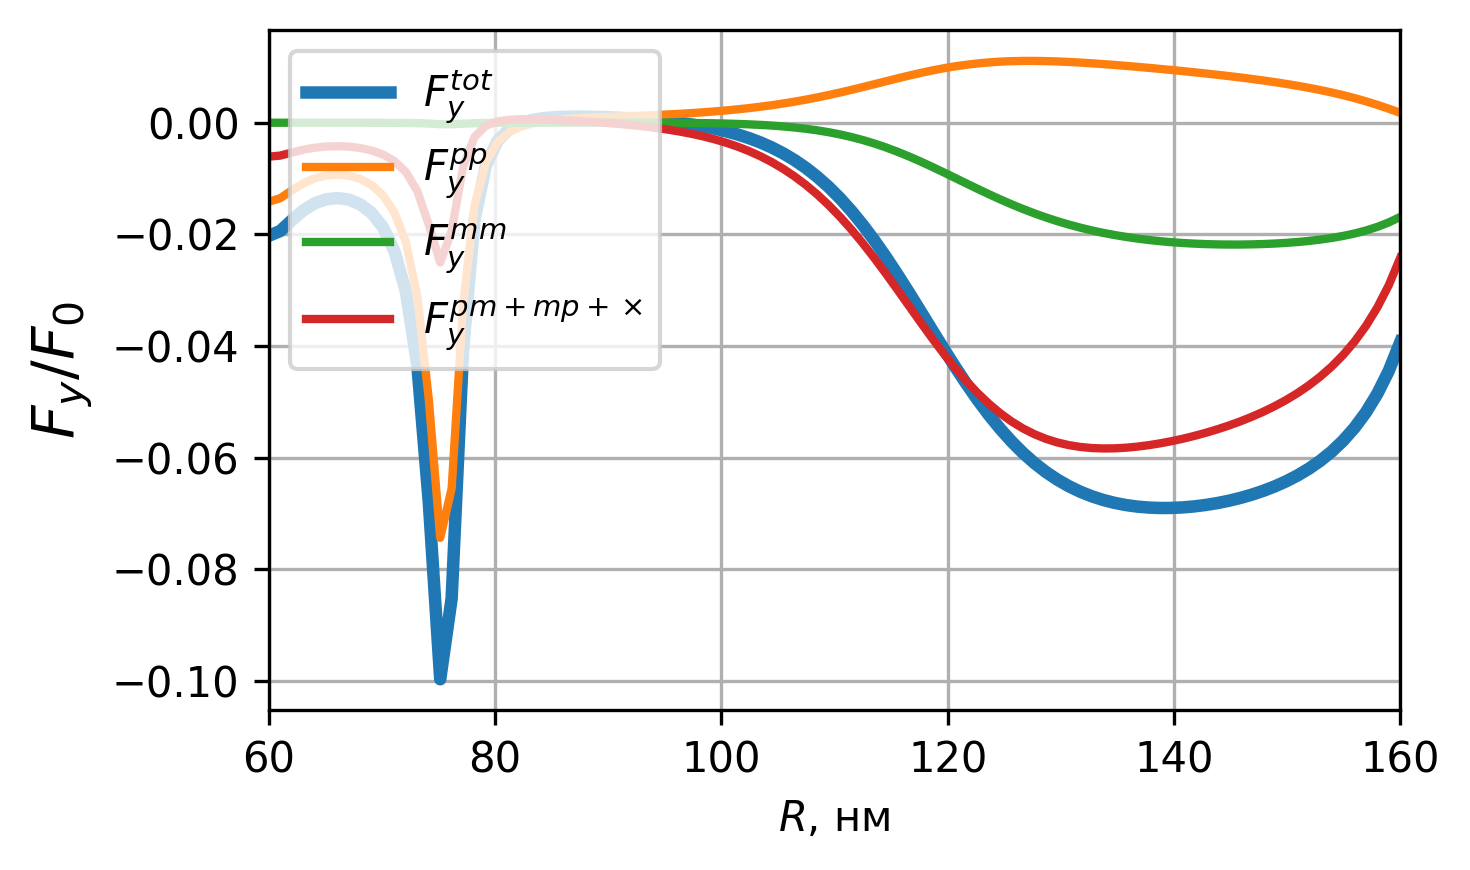

In [175]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(Rs, F_y_from_R[:,0]/fmax_Rs, label='$F_y^{tot}$', linewidth=3)
ax1.plot(Rs, F_y_from_R[:,2]/fmax_Rs, label='$F_y^{pp}$', linewidth=2)
ax1.plot(Rs, F_y_from_R[:,5]/fmax_Rs, label='$F_y^{mm}$', linewidth=2)
ax1.plot(Rs, (F_y_from_R[:,6]+F_y_from_R[:,3]+F_y_from_R[:,7])/fmax_Rs, label='$F_y^{pm+mp+\\times}$', linewidth=2)

ax1.set_ylabel('$F_y/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(loc='upper left')
ax1.set_xlabel('$R$, нм')

plt.xlim(Rs[0], Rs[-1])

plt.tight_layout()
plt.savefig(f'f_no_sc_y_from_Rs_z0_{dist}.pdf', dpi=300)
plt.show()


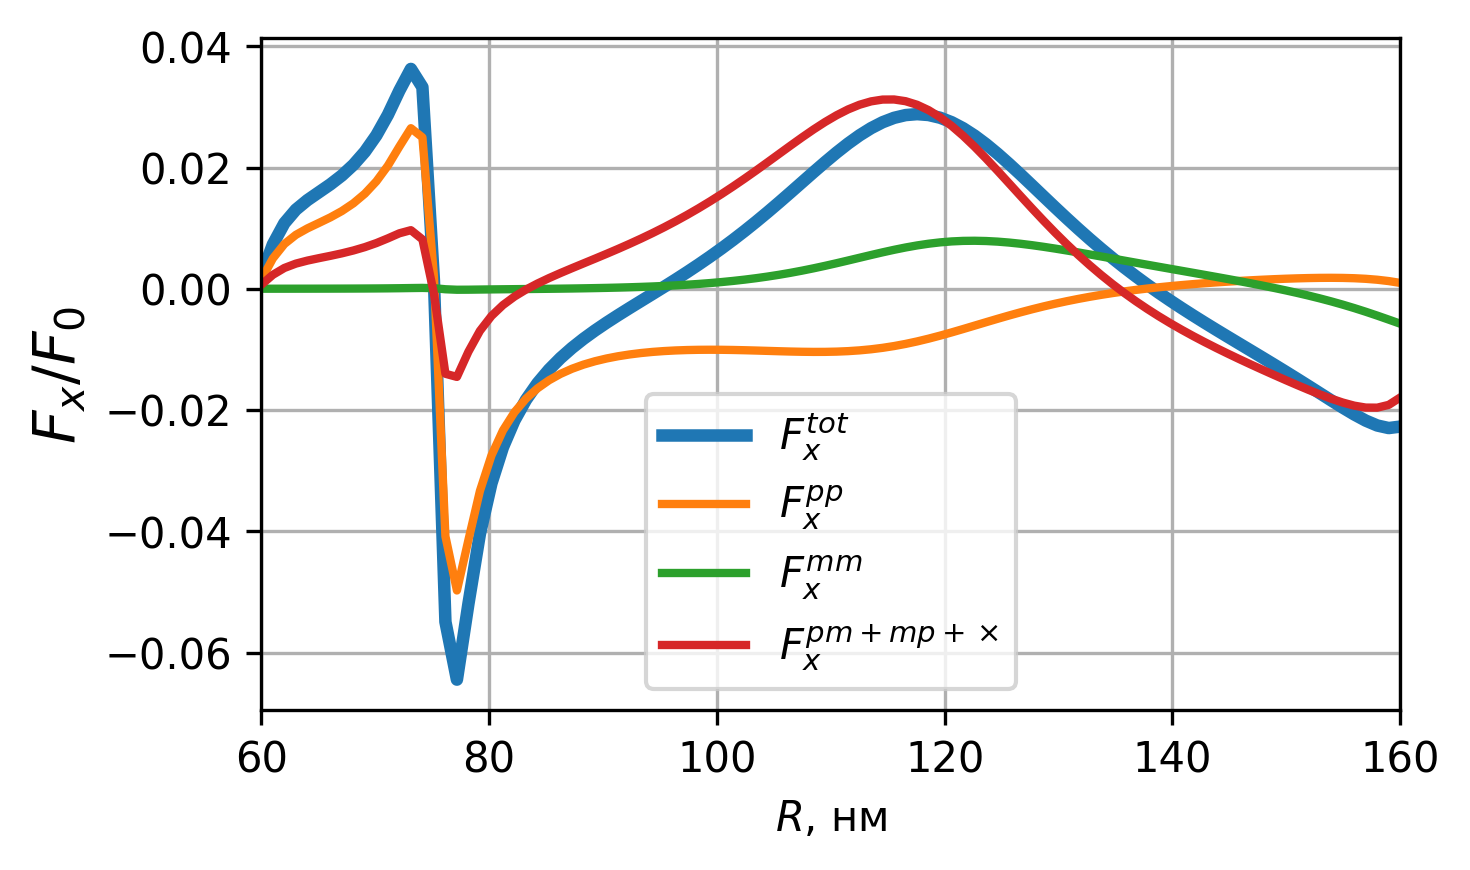

In [176]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(Rs, (F_x_from_R[:,0]-F_x_from_R[:,1]-F_x_from_R[:,4])/fmax_Rs, label='$F_x^{tot}$', linewidth=3)
ax1.plot(Rs, F_x_from_R[:,2]/fmax_Rs, label='$F_x^{pp}$', linewidth=2)
ax1.plot(Rs, F_x_from_R[:,5]/fmax_Rs, label='$F_x^{mm}$', linewidth=2)
ax1.plot(Rs, (F_x_from_R[:,6]+F_x_from_R[:,3] +F_x_from_R[:,7] )/fmax_Rs, label='$F_x^{pm+mp+\\times}$', linewidth=2)
#ax1.plot(Rs, F_x_from_R[:,7]/fmax_Rs, label='$F_x^{\\times}$', linewidth=2)

ax1.set_ylabel('$F_x/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_xlabel('$R$, нм')

plt.xlim(Rs[0], Rs[-1])

plt.tight_layout()
plt.savefig(f'f_no_sc_x_from_Rs_z0_{dist}.pdf', dpi=300)
plt.show()
